<a href="https://colab.research.google.com/github/Moonyflay/Diploma_FCA_HSE/blob/main/FCA_demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
RS1 = 49 # сид

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import sklearn
import time
import warnings

from collections import OrderedDict
from IPython.display import Image, display, clear_output
from functools import partial
from google.colab import files
from numba import njit, jit


from sklearn.compose import make_column_transformer
from sklearn.metrics import (
    make_scorer, mean_squared_error, max_error,
    root_mean_squared_error, mean_absolute_error
)
from sklearn.model_selection import (
    KFold, GridSearchCV, cross_validate, train_test_split
)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler



In [ ]:
! pip3 install wldhx.yadisk-direct &> /dev/null

In [ ]:
!curl -L $(yadisk-direct https://disk.yandex.ru/d/BErgkyezDcsotg) -o data_2.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 42959  100 42959    0     0  17235      0  0:00:02  0:00:02 --:--:-- 41426


In [ ]:
!ls

data_2.xlsx  sample_data


# Dataset preparation

In [ ]:
compounds = pd.read_excel('data_2.xlsx', sheet_name=1)
compounds.drop('Price', axis=1, inplace=True)

cultures = pd.read_excel('data_2.xlsx', sheet_name=2)

ph_ = pd.read_excel('data_2.xlsx', sheet_name=3)

results = pd.read_excel('data_2.xlsx', sheet_name=4)

## Results

results_old - старые данные, results_new - данные, полученные в этом году


In [ ]:
results_old = results.loc[:,['REE', 'Bacteria', 'Is salt', 'Stunting diameter'] ]
results_old['Is salt'] = results['Is salt'].astype(bool)
display(results_old)
print(results_old.shape)

results_new = results.loc[:,['RE, colution r', 'Concentration, mM', 'S.aureus', 'P.aeruginosa',
                             'E.coli', 'K.pneumoniae', 'C.albicans', 'C. parapsilosis', 'C. glabrata'] ]
results_new = results_new[~results_new['RE, colution r'].isna()]
results_rename = {
    'RE, colution r': 'REE',
    'S.aureus': 'Staphylococcus aureus ',
    'P.aeruginosa': 'Pseudomonas aeruginosa ',
    'E.coli': 'Escherichia coli ',
    'K.pneumoniae': 'Klebsiella pneumoniae ',
    'C.albicans': 'Candida albicans',
    'C. parapsilosis': 'Candida parapsilosis',
    'C. glabrata': 'Candida glabrata',
}
results_new.rename(results_rename, axis=1, inplace=True)
results_new['REE'] = results_new['REE'].str.strip()

tmp = pd.DataFrame(columns=['REE', 'Concentration, mM', 'Bacteria','Is salt', 'Stunting diameter'])
tmp['REE'] = results_new.loc[:,'REE']
tmp['Concentration, mM'] = results_new.loc[:,'Concentration, mM']
tmp.fillna({'Bacteria':results_new.columns[2]},  inplace=True)
tmp['Stunting diameter'] = results_new.iloc[:, 2]
for i in range(3,results_new.shape[1]):
    name = results_new.columns[i]
    tmp = pd.concat([tmp, results_new.loc[:,['REE', 'Concentration, mM']]],axis=0, ignore_index=True)
    tmp.fillna({'Bacteria':name},  inplace=True)
    tmp.iloc[(i-2)*results_new.shape[0]: (i-1)*results_new.shape[0], 4] = results_new[name]
results_new = tmp
results_new['Is salt'] = False
results_new

REE                Bacteria  Is salt  Stunting diameter
0    La  Staphylococcus aureus     False                 25
1    Ce  Staphylococcus aureus     False                 23
2    Pr  Staphylococcus aureus     False                 22
3    Nd  Staphylococcus aureus     False                 16
4    Sm  Staphylococcus aureus     False                 20
..   ..                     ...      ...                ...
190  Tm        Candida glabrata     True                 52
191  Yb        Candida glabrata     True                 41
192  Lu        Candida glabrata     True                 55
193   Y        Candida glabrata     True                 52
194  Sc        Candida glabrata     True                 39

[195 rows x 4 columns]

(195, 4)


REE  Concentration, mM                Bacteria  Is salt  Stunting diameter
0    Ce               20.0  Staphylococcus aureus     False                0.0
1    Ce               50.0  Staphylococcus aureus     False               12.0
2    Ce              100.0  Staphylococcus aureus     False               20.0
3    Ce              134.0  Staphylococcus aureus     False               22.0
4    Sm               20.0  Staphylococcus aureus     False                0.0
..   ..                ...                     ...      ...                ...
107  Gd              134.0        Candida glabrata    False                0.0
108  Yb               20.0        Candida glabrata    False                0.0
109  Yb               50.0        Candida glabrata    False                0.0
110  Yb              100.0        Candida glabrata    False                0.0
111  Yb              134.0        Candida glabrata    False                0.0

[112 rows x 5 columns]

## Compounds

В двух ячейках ниже код для преобразования электронной структуры Electronic structure RE3+ из строки в бинарные признаки  

In [ ]:
levels = ['4s','3d','4p','5s','4d','5p','6s','4f','5d']
nums = [2, 10, 6, 2, 10, 6, 2, 14, 10]
letter_lvl = {'s':'0', 'p':'1', 'd':'2', 'f':'3'}
lvl_letter  = {v: k for k, v in letter_lvl.items()}
full_lvls = OrderedDict(
    [('4s', 2),
     ('3d', 10),
     ('4p', 6),
     ('5s', 2),
     ('4d', 10),
     ('5p', 6),
     ('6s', 2),
     ('4f', 14),
     ('5d', 10)
    ]
)

In [ ]:
def decypher_el_struct(array):
    n = len(levels)
    m = len(array)
    result = {}
    for i in range(n):
        result[levels[i]] = [nums[i] for k in range(m)]

    for a in range(m):
        s = array[a].split('.')
        k = 0
        while levels[k] != s[0][0] + lvl_letter[s[0][1]]:
            k+=1
        i = 0
        while i < len(s):
            result[levels[k]][a] = int(s[i][2:])
            i+=1
            k+=1
        while k < n:
            result[levels[k]][a] = 0
            k+=1
    return result

el_struct = decypher_el_struct(compounds['Electronic structure RE3+'])
el_struct.pop('5d', None) #для 5d все значения одинаковы
el_struct

{'4s': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0],
 '3d': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0],
 '4p': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0],
 '5s': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0],
 '4d': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 0],
 '5p': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0],
 '6s': [0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0],
 '4f': [0, 0, 0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 0, 0, 0]}

Тип кристаллической структуры Crystal structure type считаем категорией и кодируем целыми числами.

Так как электронная структура для части уровней повторяется (4s, 3d, 4p и 5s, 4d, 5p заполнены одинаково и имеют только два разных значения), сгруппируем эти столбцы в один

In [ ]:
comp = pd.concat([compounds, pd.DataFrame(el_struct)], axis=1)
comp.rename({'Crystal structure type':'CrS'}, inplace=True, axis=1)
comp['CrS'] = comp['CrS'].astype('category').cat.codes
comp.loc[comp['CrS'] == -1, 'CrS'] = np.nan
comp.drop(['Electronic structure RE3+'], axis=1, inplace=True)
for i in range(len(levels[:-3])):
    comp[levels[i]] = comp[levels[i]].apply(lambda x: x == nums[i])

comp.drop(['4s', '3d', '5s', '4d'], axis=1, inplace=True)
comp.rename({'4p': 'Full up tp 4p',
                  '5p': 'Full up to 5p'},
                  axis=1, inplace=True)
comp


REE  Ionic radii  1st Ionization energy  2nd Ionization energy  \
0   La         1.03                  538.1                 1067.0   
1   Ce         1.01                  534.4                 1050.0   
2   Pr         0.99                  527.0                 1020.0   
3   Nd         0.98                  533.1                 1040.0   
4   Sm         0.96                  544.5                 1070.0   
5   Eu         0.95                  547.1                 1085.0   
6   Gd         0.94                  593.4                 1170.0   
7   Tb         0.92                  565.8                 1110.0   
8   Dy         0.91                  573.0                 1130.0   
9   Ho         0.90                  581.0                 1140.0   
10  Er         0.89                  589.3                 1150.0   
11  Tm         0.88                  596.7                 1160.0   
12  Yb         0.87                  603.4                 1174.8   
13  Lu         0.86                  523.5                 1340.0   
14   Y         0.90                  600.0                 1180.0   
15  Sc         0.75                  633.1                 1235.0   
16  Ca         1.00                  589.8                 1145.4   

    3rd Ionization energy  4th Ionization energy  CrS  (salt)  d1-1H2O  \
0                  1850.3                 4819.0  0.0            2.527   
1                  1949.0                 3547.0  0.0            2.494   
2                  2086.0                 3761.0  1.0            2.429   
3                  2130.0                 3900.0  1.0            2.429   
4                  2260.0                 3990.0  1.0            2.395   
5                  2404.0                 4120.0  1.0            2.379   
6                  1990.0                 4250.0  1.0            2.364   
7                  2114.0                 3839.0  1.0            2.350   
8                  2200.0                 3990.0  2.0            2.351   
9                  2204.0                 4100.0  2.0            2.337   
10                 2194.0                 4120.0  2.0            2.334   
11                 2285.0                 4120.0  3.0            2.323   
12                 2417.0                 4203.0  4.0            2.301   
13                 2022.3                 4370.0  5.0            2.232   
14                 1980.0                 5847.0  1.0            2.333   
15                 2388.6                 7090.6  6.0              NaN   
16                 4912.4                 6491.0  NaN              NaN   

    (salt)  d1-2H2O    (salt)  d1-3H2O    ...  R1 (Ln-N)  R2 (Ln-O)  \
0               2.554              2.585  ...        NaN        NaN   
1               2.525              2.529  ...       3.23       2.56   
2               2.447              2.456  ...       3.15       2.53   
3               2.450              2.451  ...       3.10       2.51   
4               2.420              2.421  ...       3.06       2.48   
5               2.403              2.406  ...       3.05       2.45   
6               2.389              2.392  ...       3.05       2.39   
7               2.376              2.380  ...       3.05       2.39   
8               2.358              2.401  ...       3.03       2.38   
9               2.341              2.373  ...       2.94       2.36   
10              2.339              2.365  ...       2.96       2.36   
11              2.324              2.353  ...       2.94       2.35   
12              2.308              2.337  ...       2.90       2.34   
13              2.270              2.274  ...       2.87       2.32   
14              2.353              2.354  ...        NaN        NaN   
15                NaN                NaN  ...        NaN        NaN   
16                NaN                NaN  ...        NaN        NaN   

    Coordination number solution 1(Ln-O)  \
0                                    NaN   
1                                    9.7   
2               

## Cultures

Большая часть признаков в свойствах бактерий линейно зависит друг от друга (например, Gram-stain и Wall thickness), поэтому уберем линейно зависимые столбцы. Каждый из оставшихся признаков будем считать категорией.

In [ ]:
cul = cultures.loc[:, ['Name','Gram-stain', 'Wall structure']]#, 'Well composition']]
#cul.rename({'Well composition':'Wall composition'}, axis=1, inplace=True)
cul['Gram-stain'] = cul['Gram-stain'].astype('category').cat.codes
cul

Name  Gram-stain  Wall structure
0   Staphylococcus aureus            1               1
1        Escherichia coli            0               2
2  Pseudomonas aeruginosa            0               2
3   Klebsiella pneumoniae            0               2
4            S,epidermidis           1               1
5  Acinetobacter baumannii           0               2
6    Enterococcus faecalis           1               1
7         Candida albicans          -1               2
8     Candida parapsilosis          -1               2
9         Candida glabrata          -1               2

## pH

Табличку с pH делаем вертикальной для удобства

In [ ]:
ph = ph_.iloc[:4, :].copy()
ph_rename = {
    ' Concentration, mM' : 'Concentration, mM',
    'Ce(NO3)3x6H2O': 'Ce',
    'Sm(NO3)3x6H2O': 'Sm',
    'Gd(NO3)3x6H2O': 'Gd',
    'Yb(NO3)3x5H2O': 'Yb'
}
ph.rename(ph_rename, axis=1, inplace=True)
tmp = pd.DataFrame(columns=['REE', 'pH', 'Concentration, mM'])
tmp['pH'] = np.zeros(shape=16)

tmp.fillna({'REE': ph.columns[1]},  inplace=True)
tmp['pH'] = ph.iloc[:, 1]
tmp['Concentration, mM'] = ph['Concentration, mM']

for i in range(2,ph.shape[1]):
    name = ph.columns[i]
    tmp.iloc[(i-1)*ph.shape[0]: i*ph.shape[0], 0] = name
    tmp.iloc[(i-1)*ph.shape[0]: i*ph.shape[0], 1] = ph[name]
    tmp.iloc[(i-1)*ph.shape[0]: i*ph.shape[0], 2] = ph['Concentration, mM']
ph = tmp
ph

REE    pH Concentration, mM
0   Ce  5.76                20
1   Ce  5.42                50
2   Ce  5.03               100
3   Ce  4.86               134
4   Sm  5.56                20
5   Sm  5.39                50
6   Sm  5.35               100
7   Sm  5.52               134
8   Gd  5.55                20
9   Gd  5.31                50
10  Gd  5.01               100
11  Gd  4.91               134
12  Yb  5.86                20
13  Yb  6.20                50
14  Yb  6.10               100
15  Yb  6.02               134

## Merging

### DataFrame 1 (old experiments)

Данные старых экспериментов, содержат как растворы, так и соли.

In [ ]:
df_1 = pd.merge(cul, results_old, right_on='Bacteria', left_on='Name')
df_1 = pd.merge(comp, df_1, on='REE')
df_1.drop(['Name', 'Bacteria', 'REE'], axis=1, inplace=True)
df_1 = df_1.sample(frac=1, random_state=RS1).reset_index(drop=True)
df_1.drop_duplicates(keep='first', inplace=True)
df_1

Ionic radii  1st Ionization energy  2nd Ionization energy  \
0           0.96                  544.5                 1070.0   
1           0.88                  596.7                 1160.0   
2           0.87                  603.4                 1174.8   
3           0.86                  523.5                 1340.0   
4           0.92                  565.8                 1110.0   
..           ...                    ...                    ...   
189         0.87                  603.4                 1174.8   
190         0.89                  589.3                 1150.0   
192         0.90                  600.0                 1180.0   
193         0.90                  600.0                 1180.0   
194         0.90                  600.0                 1180.0   

     3rd Ionization energy  4th Ionization energy  CrS  (salt)  d1-1H2O  \
0                   2260.0                 3990.0  1.0            2.395   
1                   2285.0                 4120.0  3.0            2.323   
2                   2417.0                 4203.0  4.0            2.301   
3                   2022.3                 4370.0  5.0            2.232   
4                   2114.0                 3839.0  1.0            2.350   
..                     ...                    ...  ...              ...   
189                 2417.0                 4203.0  4.0            2.301   
190                 2194.0                 4120.0  2.0            2.334   
192                 1980.0                 5847.0  1.0            2.333   
193                 1980.0                 5847.0  1.0            2.333   
194                 1980.0                 5847.0  1.0            2.333   

     (salt)  d1-2H2O    (salt)  d1-3H2O    (salt) d1-4H2O  ...  \
0                2.420              2.421           2.427  ...   
1                2.324              2.353           2.409  ...   
2                2.308              2.337           2.388  ...   
3                2.270              2.274             NaN  ...   
4                2.376              2.380           2.388  ...   
..                 ...                ...             ...  ...   
189              2.308              2.337           2.388  ...   
190              2.339              2.365           2.423  ...   
192              2.353              2.354           2.368  ...   
193              2.353              2.354           2.368  ...   
194              2.353              2.354           2.368  ...   

     Coordination number solution 2(Ln-O)   lgβ  Full up tp 4p  Full up to 5p  \
0                                    11.1  0.78           True           True   
1                                    12.9  0.20           True           True   
2                                    10.6  0.25           True           True   
3                                    11.8  0.56           True           True   
4                                    13.2  0.51           True           True   
..                                    ...   ...            ...            ...   
189                                  10.6  0.25           True           True   
190                                  12.7  0.15           True           True   
192                                   NaN   NaN           True          False   
193                                   NaN   NaN           True          False   
194                                   NaN   NaN           True          False   

     6s  4f  Gram-stain  Wall structure  Is salt  Stunting diameter  
0     2   3           1               1     True                 33  
1     2  10           0               2     True                 30  
2     2  11           0               2    False                 17  
3     2  12           0               2     True                 36  
4     2   6           0               2     True                 39  
..   ..  ..         ...             ...      ...                ...  
189   2  11           0               2     True       

In [ ]:
categorical_1 = np.r_[5:6, 38:40, 42:45]
df_1.columns[categorical_1]

Index(['CrS', 'Full up tp 4p', 'Full up to 5p', 'Gram-stain', 'Wall structure',
       'Is salt'],
      dtype='object')

In [ ]:
X_1 = df_1.iloc[:,:-1]
y_1 = df_1.iloc[:, -1]

### DataFrame 2 (new experiments)

Данные новых экспериментов, содержат как растворы, так и соли.

In [ ]:
df_2 = pd.merge(ph, results_new, on=['REE', 'Concentration, mM'])
df_2 = pd.merge(cul, df_2 , right_on='Bacteria', left_on='Name', how='right')
df_2 = pd.merge(comp, df_2, on='REE', how='right')
df_2.drop(['Name', 'Bacteria', 'REE', 'Concentration, mM'], axis=1, inplace=True)
df_2 = df_2.sample(frac=1, random_state=RS1).reset_index(drop=True)
df_2.drop_duplicates(keep='first', inplace=True)
df_2

Ionic radii  1st Ionization energy  2nd Ionization energy  \
0           1.01                  534.4                 1050.0   
1           0.96                  544.5                 1070.0   
2           0.96                  544.5                 1070.0   
3           0.96                  544.5                 1070.0   
4           0.94                  593.4                 1170.0   
..           ...                    ...                    ...   
94          0.94                  593.4                 1170.0   
102         0.96                  544.5                 1070.0   
103         1.01                  534.4                 1050.0   
104         0.96                  544.5                 1070.0   
111         0.96                  544.5                 1070.0   

     3rd Ionization energy  4th Ionization energy  CrS  (salt)  d1-1H2O  \
0                   1949.0                 3547.0  0.0            2.494   
1                   2260.0                 3990.0  1.0            2.395   
2                   2260.0                 3990.0  1.0            2.395   
3                   2260.0                 3990.0  1.0            2.395   
4                   1990.0                 4250.0  1.0            2.364   
..                     ...                    ...  ...              ...   
94                  1990.0                 4250.0  1.0            2.364   
102                 2260.0                 3990.0  1.0            2.395   
103                 1949.0                 3547.0  0.0            2.494   
104                 2260.0                 3990.0  1.0            2.395   
111                 2260.0                 3990.0  1.0            2.395   

     (salt)  d1-2H2O    (salt)  d1-3H2O    (salt) d1-4H2O  ...   lgβ  \
0                2.525              2.529           2.552  ...  0.69   
1                2.420              2.421           2.427  ...  0.78   
2                2.420              2.421           2.427  ...  0.78   
3                2.420              2.421           2.427  ...  0.78   
4                2.389              2.392           2.398  ...  0.47   
..                 ...                ...             ...  ...   ...   
94               2.389              2.392           2.398  ...  0.47   
102              2.420              2.421           2.427  ...  0.78   
103              2.525              2.529           2.552  ...  0.69   
104              2.420              2.421           2.427  ...  0.78   
111              2.420              2.421           2.427  ...  0.78   

     Full up tp 4p  Full up to 5p  6s  4f  Gram-stain  Wall structure    pH  \
0             True           True   1   0           0               2  4.86   
1             True           True   2   3          -1               2  5.39   
2             True           True   2   3           0               2  5.56   
3             True           True   2   3           0               2  5.35   
4             True           True   2   5          -1               2  4.91   
..             ...            ...  ..  ..         ...             ...   ...   
94            True           True   2   5           1               1  5.01   
102           True           True   2   3           0               2  5.39   
103           True           True   1   0          -1               2  5.03   
104           True           True   2   3           1               1  5.52   
111           True           True   2   3           1               1  5.35   

     Is salt  Stunting diameter  
0      False               24.0  
1      False                0.0  
2      False                0.0  
3      False               18.0  
4      False                0.0  
..       ...                ...  
94     False               12.0  
102    False               14.0  
103    False               20.0  
104    False               22.0  
111    False               17.0  

[81 rows x 47 columns]

In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 0 to 111
Data columns (total 47 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Ionic radii                            81 non-null     float64
 1   1st Ionization energy                  81 non-null     float64
 2   2nd Ionization energy                  81 non-null     float64
 3   3rd Ionization energy                  81 non-null     float64
 4   4th Ionization energy                  81 non-null     float64
 5   CrS                                    81 non-null     float64
 6   (salt)  d1-1H2O                        81 non-null     float64
 7   (salt)  d1-2H2O                        81 non-null     float64
 8   (salt)  d1-3H2O                        81 non-null     float64
 9   (salt) d1-4H2O                         81 non-null     float64
 10  (salt)  d1-5H2O                        19 non-null     float64
 11  (salt) d1-1N

In [ ]:
categorical_2 = np.r_[5:6, 38:40, 42:44, 45:46]
df_2.columns[categorical_2]

Index(['CrS', 'Full up tp 4p', 'Full up to 5p', 'Gram-stain', 'Wall structure',
       'Is salt'],
      dtype='object')

In [ ]:
X_2 = df_2.iloc[:,:-1]
y_2 = df_2.iloc[:, -1]

### DataFrame 3 (combined experiments)

Данные и старых, и новых экспериментов, содержат как растворы, так и соли.

In [ ]:
df_3 = pd.concat([df_2, df_1], axis=0, ignore_index=True)
df_3.drop_duplicates(keep='first', inplace=True)
df_3

Ionic radii  1st Ionization energy  2nd Ionization energy  \
0           1.01                  534.4                 1050.0   
1           0.96                  544.5                 1070.0   
2           0.96                  544.5                 1070.0   
3           0.96                  544.5                 1070.0   
4           0.94                  593.4                 1170.0   
..           ...                    ...                    ...   
256         0.87                  603.4                 1174.8   
257         0.89                  589.3                 1150.0   
258         0.90                  600.0                 1180.0   
259         0.90                  600.0                 1180.0   
260         0.90                  600.0                 1180.0   

     3rd Ionization energy  4th Ionization energy  CrS  (salt)  d1-1H2O  \
0                   1949.0                 3547.0  0.0            2.494   
1                   2260.0                 3990.0  1.0            2.395   
2                   2260.0                 3990.0  1.0            2.395   
3                   2260.0                 3990.0  1.0            2.395   
4                   1990.0                 4250.0  1.0            2.364   
..                     ...                    ...  ...              ...   
256                 2417.0                 4203.0  4.0            2.301   
257                 2194.0                 4120.0  2.0            2.334   
258                 1980.0                 5847.0  1.0            2.333   
259                 1980.0                 5847.0  1.0            2.333   
260                 1980.0                 5847.0  1.0            2.333   

     (salt)  d1-2H2O    (salt)  d1-3H2O    (salt) d1-4H2O  ...   lgβ  \
0                2.525              2.529           2.552  ...  0.69   
1                2.420              2.421           2.427  ...  0.78   
2                2.420              2.421           2.427  ...  0.78   
3                2.420              2.421           2.427  ...  0.78   
4                2.389              2.392           2.398  ...  0.47   
..                 ...                ...             ...  ...   ...   
256              2.308              2.337           2.388  ...  0.25   
257              2.339              2.365           2.423  ...  0.15   
258              2.353              2.354           2.368  ...   NaN   
259              2.353              2.354           2.368  ...   NaN   
260              2.353              2.354           2.368  ...   NaN   

     Full up tp 4p  Full up to 5p  6s  4f  Gram-stain  Wall structure    pH  \
0             True           True   1   0           0               2  4.86   
1             True           True   2   3          -1               2  5.39   
2             True           True   2   3           0               2  5.56   
3             True           True   2   3           0               2  5.35   
4             True           True   2   5          -1               2  4.91   
..             ...            ...  ..  ..         ...             ...   ...   
256           True           True   2  11           0               2   NaN   
257           True           True   2   9           1               1   NaN   
258           True          False   0   0           0               2   NaN   
259           True          False   0   0          -1               2   NaN   
260           True          False   0   0           1               1   NaN   

     Is salt  Stunting diameter  
0      False               24.0  
1      False                0.0  
2      False                0.0  
3      False               18.0  
4      False                0.0  
..       ...                ...  
256     True               30.0  
257     True               48.0  
258     True               28.0  
259     True               51.0  
260     True               50.0  

[261 rows x 47 columns]

In [ ]:
categorical_3 = np.r_[5:6, 38:40, 42:44, 45 ]
df_3.columns[categorical_3]

Index(['CrS', 'Full up tp 4p', 'Full up to 5p', 'Gram-stain', 'Wall structure',
       'Is salt'],
      dtype='object')

In [ ]:
X_3 = df_3.iloc[:,:-1]
y_3 = df_3.iloc[:, -1]

In [ ]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       ):
  display(df_3[X_3.duplicated(keep=False)].sort_values(by=['Ionic radii', 'Gram-stain']))

Ionic radii  1st Ionization energy  2nd Ionization energy  \
118         0.75                  633.1                 1235.0   
210         0.75                  633.1                 1235.0   
223         0.75                  633.1                 1235.0   
134         0.75                  633.1                 1235.0   
154         0.75                  633.1                 1235.0   
170         0.75                  633.1                 1235.0   
231         0.75                  633.1                 1235.0   
123         0.75                  633.1                 1235.0   
252         0.75                  633.1                 1235.0   
105         0.86                  523.5                 1340.0   
171         0.86                  523.5                 1340.0   
245         0.86                  523.5                 1340.0   
84          0.86                  523.5                 1340.0   
98          0.86                  523.5                 1340.0   
120         0.86                  523.5                 1340.0   
248         0.86                  523.5                 1340.0   
179         0.86                  523.5                 1340.0   
181         0.86                  523.5                 1340.0   
182         0.86                  523.5                 1340.0   
19          0.87                  603.4                 1174.8   
26          0.87                  603.4                 1174.8   
31          0.87                  603.4                 1174.8   
41          0.87                  603.4                 1174.8   
45          0.87                  603.4                 1174.8   
63          0.87                  603.4                 1174.8   
64          0.87                  603.4                 1174.8   
72          0.87                  603.4                 1174.8   
102         0.87                  603.4                 1174.8   
184         0.87                  603.4                 1174.8   
214         0.87                  603.4                 1174.8   
7           0.87                  603.4                 1174.8   
12          0.87                  603.4                 1174.8   
16          0.87                  603.4                 1174.8   
33          0.87                  603.4                 1174.8   
37          0.87                  603.4                 1174.8   
38          0.87                  603.4                 1174.8   
40          0.87                  603.4                 1174.8   
55          0.87                  603.4                 1174.8   
66          0.87                  603.4                 1174.8   
70          0.87                  603.4                 1174.8   
74          0.87                  603.4                 1174.8   
83          0.87                  603.4                 1174.8   
143         0.87                  603.4                 1174.8   
149         0.87                  603.4                 1174.8   
190         0.87                  603.4                 1174.8   
243         0.87                  603.4                 1174.8   
256         0.87                  603.4                 1174.8   
199         0.87                  603.4                 1174.8   
227         0.87                  603.4                 1174.8   
203         0.88                  596.7                 1160.0   
217         0.88                  596.7                 1160.0   
247         0.88                  596.7                 1160.0   
82          0.88                  596.7                 1160.0   
96          0.88                  596.7                 1160.0   
125         0.88                  596.7                 1160.0   
135         0.88                  596.7                 1160.0   
138         0.88                  596.7                 1160.0   
189         0.88                  596.7                 1160.0   
255         0.88                  596.7                 1160.0   
130         0.89                  589.3      

### DataFrame 4 (salt only)

Данные и старых, и новых экспериментов, содержат только соли. Признаки, относящиеся только к растворам, убраны

In [ ]:
df_4 = df_3.drop(['pH'], axis=1)
df_4 = df_4[df_4['Is salt'] == True]
df_4.drop(df_4.columns[31:38], axis=1, inplace=True)
df_4.drop(['Is salt'], axis=1, inplace=True)
df_4 = df_4.sample(frac=1, random_state=RS1).reset_index(drop=True)
df_4

Ionic radii  1st Ionization energy  2nd Ionization energy  \
0           0.91                  573.0                 1130.0   
1           0.87                  603.4                 1174.8   
2           1.03                  538.1                 1067.0   
3           0.98                  533.1                 1040.0   
4           0.98                  533.1                 1040.0   
..           ...                    ...                    ...   
125         0.92                  565.8                 1110.0   
126         1.03                  538.1                 1067.0   
127         0.88                  596.7                 1160.0   
128         0.89                  589.3                 1150.0   
129         0.94                  593.4                 1170.0   

     3rd Ionization energy  4th Ionization energy  CrS  (salt)  d1-1H2O  \
0                   2200.0                 3990.0  2.0            2.351   
1                   2417.0                 4203.0  4.0            2.301   
2                   1850.3                 4819.0  0.0            2.527   
3                   2130.0                 3900.0  1.0            2.429   
4                   2130.0                 3900.0  1.0            2.429   
..                     ...                    ...  ...              ...   
125                 2114.0                 3839.0  1.0            2.350   
126                 1850.3                 4819.0  0.0            2.527   
127                 2285.0                 4120.0  3.0            2.323   
128                 2194.0                 4120.0  2.0            2.334   
129                 1990.0                 4250.0  1.0            2.364   

     (salt)  d1-2H2O    (salt)  d1-3H2O    (salt) d1-4H2O  ...  \
0                2.358              2.401           2.448  ...   
1                2.308              2.337           2.388  ...   
2                2.554              2.585           2.560  ...   
3                2.450              2.451           2.463  ...   
4                2.450              2.451           2.463  ...   
..                 ...                ...             ...  ...   
125              2.376              2.380           2.388  ...   
126              2.554              2.585           2.560  ...   
127              2.324              2.353           2.409  ...   
128              2.339              2.365           2.423  ...   
129              2.389              2.392           2.398  ...   

     Electronegativity, Malliken  Electronegativity, Poland  \
0                           3.15                       1.22   
1                           3.12                       1.10   
2                           3.06                       1.10   
3                           3.72                       1.14   
4                           3.72                       1.14   
..                           ...                        ...   
125                         3.51                       1.10   
126                         3.06                       1.10   
127                         3.61                       1.25   
128                         3.21                       1.24   
129                         3.14                       1.20   

     Electronegativity, Allred-Rochow  Full up tp 4p  Full up to 5p  6s  4f  \
0                                1.10           True           True   2   7   
1                                1.06           True           True   2  11   
2                                1.08           True           True   0   0   
3                                1.07           True           True   2   1   
4                                1.07           True           True   2   1   
..                                ...            ...            ...  ..  ..   
125                              1.10           True           True   2   6   
126                              1.08           True           True   0   0   
127                              1.11           Tr

In [ ]:
categorical_4 = np.r_[5:6, 31:33, 35:37]
df_4.columns[categorical_4]

Index(['CrS', 'Full up tp 4p', 'Full up to 5p', 'Gram-stain',
       'Wall structure'],
      dtype='object')

In [ ]:
X_4 = df_4.iloc[:,:-1]
y_4 = df_4.iloc[:, -1]

### DataFrame 5 (solution only)

Данные и старых, и новых экспериментов, содержат как растворы, так и соли. Признаки, относящиеся только к солям, убраны

In [ ]:
df_5 = df_3[df_3['Is salt'] == False].drop('Is salt', axis=1)
df_5.drop(df_5.columns[5:25], axis=1, inplace=True)
df_5.reset_index(drop=True, inplace=True)
df_5

Ionic radii  1st Ionization energy  2nd Ionization energy  \
0           1.01                  534.4                 1050.0   
1           0.96                  544.5                 1070.0   
2           0.96                  544.5                 1070.0   
3           0.96                  544.5                 1070.0   
4           0.94                  593.4                 1170.0   
..           ...                    ...                    ...   
126         1.03                  538.1                 1067.0   
127         0.91                  573.0                 1130.0   
128         0.86                  523.5                 1340.0   
129         1.00                  589.8                 1145.4   
130         0.88                  596.7                 1160.0   

     3rd Ionization energy  4th Ionization energy    x    n  \
0                   1949.0                 3547.0  1.0  5.0   
1                   2260.0                 3990.0  2.0  4.0   
2                   2260.0                 3990.0  2.0  4.0   
3                   2260.0                 3990.0  2.0  4.0   
4                   1990.0                 4250.0  2.0  4.0   
..                     ...                    ...  ...  ...   
126                 1850.3                 4819.0  1.0  5.0   
127                 2200.0                 3990.0  1.0  4.0   
128                 2022.3                 4370.0  0.0  3.0   
129                 4912.4                 6491.0  NaN  NaN   
130                 2285.0                 4120.0  1.0  4.0   

     Electronegativity, Oganov  Electronegativity, Malliken  \
0                         2.61                        3.050   
1                         1.90                        2.900   
2                         1.90                        2.900   
3                         1.90                        2.900   
4                         2.40                        3.140   
..                         ...                          ...   
126                       2.49                        3.060   
127                       2.07                        3.150   
128                       2.68                        2.890   
129                       2.20                        3.255   
130                       2.03                        3.610   

     Electronegativity, Poland  ...  Coordination number solution 2(Ln-O)  \
0                         1.12  ...                                   9.5   
1                         1.17  ...                                  11.1   
2                         1.17  ...                                  11.1   
3                         1.17  ...                                  11.1   
4                         1.20  ...                                  13.2   
..                         ...  ...                                   ...   
126                       1.10  ...                                   NaN   
127                       1.22  ...                                  13.1   
128                       1.27  ...                                  11.8   
129                       1.00  ...                                   NaN   
130                       1.25  ...                                  12.9   

      lgβ  Full up tp 4p  Full up to 5p  6s  4f  Gram-stain  Wall structure  \
0    0.69           True           True   1   0           0               2   
1    0.78           True           True   2   3          -1               2   
2    0.78           True           True   2   3           0               2   
3    0.78           True           True   2   3           0               2   
4    0.47           True           True   2   5          -1               2   
..    ...            ...            ...  ..  ..         ...             ...   
126  0.58           True           True   0   0           0               2   
127  0.15           True           True   2   7           0               2   
128  0.56           True           True   2  12           0   

In [ ]:
categorical_5 = np.r_[18:20, 22:24]
df_5.columns[categorical_5]

Index(['Full up tp 4p', 'Full up to 5p', 'Gram-stain', 'Wall structure'], dtype='object')

In [ ]:
X_5 = df_5.iloc[:,:-1]
y_5 = df_5.iloc[:, -1]

In [ ]:
print(X_3.shape, X_4.shape, X_5.shape)

(261, 46) (130, 37) (131, 25)


### Creating nonan datasets

In [ ]:
df_3_nona = df_3.dropna(axis=1)
df_3_nona = df_3_nona.drop_duplicates()
X_3_nona = df_3_nona.iloc[:,:-1]
y_3_nona = df_3_nona.iloc[:, -1]

categorical_3_nona = np.r_[8:10, 12:15]
df_3_nona.columns[categorical_3_nona]

Index(['Full up tp 4p', 'Full up to 5p', 'Gram-stain', 'Wall structure',
       'Is salt'],
      dtype='object')

In [ ]:
df_4_nona = df_4.dropna(axis=1)
df_4_nona = df_4_nona.drop_duplicates()
X_4_nona = df_4_nona.iloc[:,:-1]
y_4_nona = df_4_nona.iloc[:, -1]

categorical_4_nona = np.r_[8:10, 12:14]
df_4_nona.columns[categorical_4_nona]

Index(['Full up tp 4p', 'Full up to 5p', 'Gram-stain', 'Wall structure'], dtype='object')

In [ ]:
df_5_nona = df_5.dropna(axis=1)
df_5_nona = df_5_nona.drop_duplicates()

X_5_nona = df_5_nona.iloc[:,:-1]
y_5_nona = df_5_nona.iloc[:, -1]

categorical_5_nona = np.r_[8:10, 12:14]
df_5_nona.columns[categorical_5_nona]

Index(['Full up tp 4p', 'Full up to 5p', 'Gram-stain', 'Wall structure'], dtype='object')

In [ ]:
print(X_3_nona.shape, X_4_nona.shape, X_5_nona.shape)

(238, 15) (130, 14) (108, 14)


### train test splits

In [ ]:
na_dfs = [(X_3, y_3), (X_4, y_4), (X_5, y_5)]
na_list = []
for x_, y_ in na_dfs:
    na_list.append(train_test_split(x_, y_, random_state=RS1, test_size=0.2))

nona_dfs = [(X_3_nona, y_3_nona), (X_4_nona, y_4_nona), (X_5_nona, y_5_nona)]
nona_list = []
for x_, y_ in nona_dfs:
    nona_list.append(train_test_split(x_, y_, random_state=RS1, test_size=0.2))


In [ ]:
nona_categorical = [categorical_3_nona, categorical_4_nona, categorical_5_nona]

In [ ]:
na_categorical = [categorical_3, categorical_4, categorical_5]

# Method testing

## FCARegressor

In [ ]:
class FCARegressor():
    def __init__(self, sample_size_max, sample_per_object, use_y):
        self.sample_size_max = sample_size_max
        self.sample_per_object = sample_per_object
        self.use_y = use_y

        self.fitted = False # вызывался ли метод fit
        self.hyps_formed = False # вызывался ли метод form_hyps
        self.predicted = True
        return

    def fit(self, X_train, y_train, categorical):
        self.indices = np.isin(range(X_train.shape[1]), categorical)
        self.indices = ~self.indices

        # разделяем таблицу признаков на две: числовую и категориальную
        self.X_train_num = X_train[:, self.indices].astype(float)
        self.X_train_cat = X_train[:, ~self.indices].astype(float)
        self.y = y_train

        self.train_num = X_train.shape[0]
        self.num_fnum = self.X_train_num.shape[1]
        self.cat_fnum = self.X_train_cat.shape[1]

        self.fitted = True
        return

    def set_parameters(
            self, feature_tol, hyp_num,
            min_extent_size, hyp_weighing,
            samp_size_low, samp_size_high
        ):

        sample_per_object = self.sample_per_object
        if hyp_num < 1:
            hyp_num = 1
        elif hyp_num > sample_per_object * self.train_num:
            hyp_num = sample_per_object * self.train_num

        if hyp_weighing == 0:
            hyp_weighing = 'var'
        elif hyp_weighing == 1:
            hyp_weighing = 'ones'
        elif hyp_weighing == 2:
            hyp_weighing = 'change'

        if samp_size_high is None:
            samp_size_high = self.sample_size_max

        if samp_size_low < 0 or samp_size_low is None:
            samp_size_low = 0

        indices = self.indices
        num_feature_tol = None
        cat_feature_tol = None
        if feature_tol is not None:
            num_feature_tol = feature_tol[indices]
            cat_feature_tol = feature_tol[~indices]
        if num_feature_tol is None:
            num_feature_tol = np.ones(self.num_fnum)
        if cat_feature_tol is None:
            cat_feature_tol = np.ones(self.cat_fnum)

        self.samp_size_low = samp_size_low
        self.samp_size_high = samp_size_high
        self.hyp_num = hyp_num
        self.min_extent_size = min_extent_size
        self.hyp_weighing = hyp_weighing
        self.num_feature_tol = num_feature_tol
        self.cat_feature_tol = cat_feature_tol

        return

    @staticmethod
    @jit(nopython=True)
    def sample(sample_per_object, sample_size_max, y, use_y):
        obj_num = len(y)
        indices = np.zeros(
            shape=(obj_num, sample_per_object, sample_size_max), dtype='i4'
        )
        y_distances = np.zeros(shape=(obj_num, obj_num))
        if use_y:
            y_distances = np.abs(y[:, np.newaxis] - y[np.newaxis, :])
        np.fill_diagonal(y_distances, np.inf)
        probs = 1 / (1 + y_distances)
        probs /= np.sum(probs, axis=1)[:, None]

        for obj in range(obj_num):
            cum_probs = np.cumsum(probs[obj])
            for samp in range(sample_per_object):
                indices[obj, samp] = obj
                for i in range(1, sample_size_max):
                    random_value = np.random.rand()
                    idx = np.searchsorted(cum_probs, random_value)
                    while idx in indices[obj, samp]:
                        random_value = np.random.rand()
                        idx = np.searchsorted(cum_probs, random_value)
                    indices[obj, samp, i] = idx

        indices = indices.reshape(-1, sample_size_max)
        return indices #[sample_num, sample_size]

    def intersect_numeric(self, train_samples):
        # bounds_num.shape = [2, sample_num, (numerical) feature_num]
        bounds_num = np.empty(shape=(2, train_samples.shape[0], self.num_fnum))
        bounds_num[0] = np.min(train_samples, axis=1)
        bounds_num[1] = np.max(train_samples, axis=1)
        return bounds_num

    def calculate_distance(self, bound_num, bound_cat):

        X_train_num = self.X_train_num
        X_test_num = self.X_test_num
        X_train_cat = self.X_train_cat
        X_test_cat = self.X_test_cat
        sample_num = bound_num.shape[1]

        distance = np.zeros(shape=(self.test_num, sample_num))

        # ____ numerical distance ____
        normalize_train = (
            np.nanmax(X_train_num, axis=0)
            - np.nanmin(X_train_num, axis=0)
        )
        normalize_train[normalize_train == 0] += 1e-6

        distance_num_test = np.zeros(
            shape=(self.test_num, sample_num, self.num_fnum)
        )
        distance_num_train = np.zeros(
            shape=(self.train_num, sample_num, self.num_fnum)
        )
        # (sample_num, feature_num)
        nan_mask = np.isnan(bound_num[0]) | (normalize_train <= 1e-6)

        # ((x < a)(a - x) + (x > b)(x - b))/n

        distance_num_test = np.where(nan_mask, 0, (
                (bound_num[0, None] > X_test_num[:, None])
                * (bound_num[0, None] - X_test_num[:, None])
                + (bound_num[1, None] < X_test_num[:, None])
                * (X_test_num[:, None] - bound_num[1, None])
            ) / normalize_train
        )
        distance_num_test = np.nan_to_num(distance_num_test, nan=1)

        distance_num_train = np.where(nan_mask, 0, (
            (bound_num[0, None] > X_train_num[:, None])
            * (bound_num[0, None] - X_train_num[:, None])
            + (bound_num[1, None] < X_train_num[:, None])
            * (X_train_num[:, None] - bound_num[1, None])
            ) / normalize_train
        )
        distance_num_train = np.nan_to_num(distance_num_train, nan=1)

        # ___ categorical distance ___
        distance_cat_test = np.zeros(
            shape=(self.test_num, sample_num, self.cat_fnum)
        )
        distance_cat_train = np.zeros(
            shape=(self.train_num, sample_num, self.cat_fnum)
        )
        # check it _________________________________________________________________
        nan_mask = np.isnan(bound_cat).sum(axis=1, keepdims=True).astype(bool)
        uneq_cats_test = ~(
            (X_test_cat[:, None, None] == bound_cat[None])
            | nan_mask
        )
        uneq_cats_train = ~(
            (X_train_cat[:, None, None] == bound_cat[None])
            | nan_mask
        )

        distance_cat_test = 0. + np.prod(uneq_cats_test, axis=2).astype(bool)
        distance_cat_train = 0. + np.prod(uneq_cats_train, axis=2).astype(bool)

        # ____ duplicate removal ____
        distance_train_tmp = np.concatenate(
            [distance_num_train, distance_cat_train],
            axis=-1
        )
        _, unique_id = np.unique(distance_train_tmp, axis=1, return_index=True)
        unique_id = np.sort(unique_id)

        detailed_dist = {
            'distance_num_train': distance_num_train[:, unique_id],
            'distance_cat_train': distance_cat_train[:, unique_id],
            'distance_num_test': distance_num_test[:, unique_id],
            'distance_cat_test': distance_cat_test[:, unique_id]
        }
        return detailed_dist, unique_id

    def find_extent(
            self,
            distance_num_train, distance_num_test,
            distance_cat_train, distance_cat_test,
            num_feature_tol, cat_feature_tol
        ):
        num_fits_train = np.less_equal(distance_num_train, num_feature_tol)
        cat_fits_train = np.less_equal(distance_cat_train, cat_feature_tol)
        extent_train = np.prod(num_fits_train, axis=-1).astype(bool)
        extent_train *= np.prod(cat_fits_train, axis=-1).astype(bool)
        _, unique_id = np.unique(extent_train, return_index=True, axis=1)
        unique_id = np.sort(unique_id)
        extent_train = extent_train[:, unique_id]

        num_fits_test = np.less_equal(distance_num_test, num_feature_tol)
        cat_fits_test = np.less_equal(distance_cat_test, cat_feature_tol)
        extent_test = np.prod(num_fits_test, axis=-1).astype(bool)
        extent_test *= np.prod(cat_fits_test, axis=-1).astype(bool)
        extent_test = extent_test[:, unique_id]
        return (extent_train, extent_test), unique_id

    @staticmethod
    @jit(nopython=True)
    def describe_extent(extent, y):
        sample_num = extent.shape[1]
        mean = np.zeros(shape=(1, sample_num )) # shape = [1, sample_num]
        variance = np.zeros_like(mean)
        sizes = np.zeros_like(mean, dtype='i4')
        for i in range(sample_num):
            y_tmp = y[extent[:, i]]
            if len(y_tmp) < 1:
                sizes[0, i] = 0
                mean[0, i] = -50
                variance[0, i] = 0
                continue
            sizes[0, i] = np.sum(extent[:, i])
            mean[0, i] = y_tmp.mean()
            variance[0, i] = y_tmp.var()
        return mean, variance, sizes

    @staticmethod
    @jit(nopython=True)
    def pick_hyps(extents, y, hyp_num, min_extent_size, describe_extent):
        extent_train, extent_test = extents
        sample_num = extent_train.shape[1]
        test_num = extent_test.shape[0]
        train_num = extent_train.shape[0]

        extent_description = describe_extent(extent_train, y)
        mean, vars, sizes = extent_description
        _, vars_inv, sizes_inv = describe_extent(~extent_train, y)
        var_change = (sizes * vars + sizes_inv * vars_inv) / train_num
        enough_size = sizes[0] > min_extent_size

        chosen_hyps = []
        for t in range(test_num):
            mask = extent_test[t] & enough_size
            candidates = np.arange(sample_num)[mask]
            if len(candidates) > hyp_num:
                best = np.argsort(var_change[0, candidates])[:hyp_num]
                candidates = candidates[best]
            chosen_hyps.append(candidates)

        return chosen_hyps, extent_description, var_change

    @staticmethod
    @jit(nopython=True)
    def calculate_y(chosen_hyps, extent_description, var_change, hyp_weighing):
        test_num = len(chosen_hyps)
        mean, vars, sizes = extent_description

        weights = []
        if hyp_weighing == 'var':
            weights_ = 1 / (1 + vars[0])
            for t in range(test_num):
                weights.append(weights_[chosen_hyps[t]])
        elif hyp_weighing == 'ones':
            weights = [np.ones(len(chosen_hyps[t])) for t in range(test_num)]
        elif hyp_weighing == 'change':
            weights = [var_change[0, chosen_hyps[t]] for t in range(test_num)]

        weighted_mean = np.zeros(shape=test_num)
        hyp_means = []
        for t in range(test_num):
            mean_ = mean[0, chosen_hyps[t]]
            hyp_means.append(mean_)
            if len(chosen_hyps[t]) == 0:
                weighted_mean[t] = np.nan
                continue
            weighted_mean[t] = np.average(mean_,  weights=weights[t])

        extra_stats = (hyp_means, weights)
        return weighted_mean, extra_stats

    def form_hyps(self, X_test):
        if not self.fitted:
            raise Exception('This FCARegressor instance is not fitted yet. '
                            'Call \"fit\" with appropriate arguments before '
                            'using this estimator.')

        self.X_test_num = X_test[:, self.indices].astype(float)
        self.X_test_cat = X_test[:, ~self.indices].astype(float)
        self.test_num = X_test.shape[0]

        bounds_num_list = []
        bounds_cat_list = []
        detailed_list = []
        sample_idx_list = [0]

        samples_ = self.sample(
            self.sample_per_object, self.sample_size_max, self.y, self.use_y
        )
        for i in range(1, self.sample_size_max + 1):
            samples = samples_[:, :i]
            samples = np.unique(np.sort(samples, axis=-1), axis=0)

            # X_train_num[samples].shape = [samp_num, sample_size, feature_num]
            bounds_num_i = self.intersect_numeric(self.X_train_num[samples])

            # X_train_cat[samples].shape = [samp_num, sample_size, feature_num]
            bounds_cat_i = self.X_train_cat[samples]

            detailed_dist_i, unique_id = self.calculate_distance(
                bounds_num_i, bounds_cat_i
            )
            samp_num_ = len(unique_id)
            sample_idx_list.append(samp_num_ + sample_idx_list[-1])

            bounds_num_i = bounds_num_i[:, unique_id]
            bounds_cat_i = bounds_cat_i[unique_id]

            bounds_num_list.append(bounds_num_i)
            bounds_cat_list.append(bounds_cat_i)
            detailed_list.append(detailed_dist_i)

        bounds_num = np.concatenate(bounds_num_list, axis=1)

        bounds_cat = np.empty(
            shape=(bounds_num.shape[1],
                bounds_cat_list[-1].shape[1] + 1, # sample_size + 1 for test
                bounds_cat_list[-1].shape[-1]),
        )
        prev = 0
        next = 0
        for i in range(len(bounds_cat_list)):
            next += len(bounds_cat_list[i])
            bounds_cat[prev:next] = bounds_cat_list[i][:, 0, None]
            last_idx = len(bounds_cat_list[i][0])
            bounds_cat[prev:next, :last_idx] = bounds_cat_list[i]
            prev = next

        detailed_dist = {}
        for key in detailed_list[0]:
            detailed_dist[key] = []
            for det in detailed_list:
                detailed_dist[key].append(det[key])
            detailed_dist[key] = np.concatenate(detailed_dist[key], axis=1)

        self.samples_ = samples_
        self.bounds_num = bounds_num
        self.bounds_cat = bounds_cat
        self.detailed_dist = detailed_dist
        self.sample_idx_list = sample_idx_list
        self.hyps_formed = True
        return

    def predict(
            self, hyp_num=1, min_extent_size=1, hyp_weighing='var',
            feature_tol=None, samp_size_low=0, samp_size_high=None

        ):
        if not self.hyps_formed:
            raise Exception('This FCARegressor did not form hypotheses yet. '
                            'Call \"form_hyps\" with appropriate arguments '
                            'before using this estimator.')

        self.set_parameters(
            feature_tol, hyp_num,
            min_extent_size, hyp_weighing,
            samp_size_low, samp_size_high
        )

        low = self.sample_idx_list[self.samp_size_low]
        high = self.sample_idx_list[self.samp_size_high]
        detailed_dist_ = self.detailed_dist.copy()
        for key in detailed_dist_:
            detailed_dist_[key] = detailed_dist_[key][:, low:high]

        extents, unique_id = self.find_extent(
            **detailed_dist_,
            num_feature_tol=self.num_feature_tol,
            cat_feature_tol=self.cat_feature_tol
        )
        chosen_hyps, extent_description, var_change = self.pick_hyps(
            extents, self.y, self.hyp_num, self.min_extent_size,
            describe_extent=self.describe_extent
        )
        y_pred, extra_stats = self.calculate_y(
            chosen_hyps, extent_description, var_change, self.hyp_weighing
        )
        self.unique_id = unique_id
        self.extents = extents
        self.chosen_hyps = chosen_hyps
        self.extent_description = extent_description
        self.var_change = var_change
        self.y_pred = y_pred
        self.extra_stats = extra_stats
        self.predicted = True
        return y_pred

    def explain_predictions(self, feature_names):
        if not self.predicted:
            raise Exception('This FCARegressor did not do any predictions yet. '
                            'Call \"predict\" with appropriate arguments '
                            'before using this estimator.')
        cols = np.array(feature_names)
        num_cols = cols[self.indices]
        cat_cols = cols[~self.indices]
        holder = pd.DataFrame(columns=np.concatenate([cols, ['y', 'w']]))
        num_holder = pd.DataFrame(columns=range(len(num_cols))).astype(str)
        cat_holder = pd.DataFrame(columns=range(len(cat_cols))).astype(str)
        y_holder = pd.DataFrame(columns=['y', 'w'])
        last_idx = num_holder.shape[0]
        for test_i in range(self.test_num):
            num_holder.loc[last_idx] = self.X_test_num[test_i].astype(str)
            cat_holder.loc[last_idx] = self.X_test_cat[test_i].astype(str)
            y_holder.loc[last_idx, 'y'] = np.round(self.y_pred[test_i], 3)
            y_holder.loc[last_idx, 'w'] = ''
            # getting initial number of hyp
            hyps_i = self.unique_id[self.chosen_hyps[test_i]]

            bounds_num_i = self.bounds_num[:, hyps_i]
            for k in range(len(hyps_i)):
                last_idx += 1
                for j in range(bounds_num_i.shape[-1]):
                    left = bounds_num_i[0, k, j]
                    right = bounds_num_i[1, k, j]
                    s = f'[{left}, {right}]'
                    num_holder.loc[last_idx, j] = s

                for j in range(self.bounds_cat.shape[-1]):
                    bounds_cat_i = set(self.bounds_cat[hyps_i[k], :, j])
                    bounds_cat_i = {int(b) for b in bounds_cat_i}
                    s = f'{bounds_cat_i}'
                    cat_holder.loc[last_idx, j] = s

                y_ = np.round(self.extra_stats[0][test_i][k], 3)
                w_ = np.round(self.extra_stats[1][test_i][k], 3)
                y_holder.loc[last_idx, 'y'] = str(y_)
                y_holder.loc[last_idx, 'w'] = str(w_)

            last_idx += 1
            num_holder.loc[last_idx] = ['' for f in range(len(num_cols))]
            cat_holder.loc[last_idx] = ['' for f in range(len(cat_cols))]
            y_holder.loc[last_idx] = ['' for f in range(2)]
            last_idx += 1

        num_holder.rename(
            {f: num_cols[f] for f in range(len(num_cols))},
            inplace=True, axis=1
        )
        cat_holder.rename(
            {f: cat_cols[f] for f in range(len(cat_cols))},
            inplace=True, axis=1
        )
        holder[num_cols] = num_holder
        holder[cat_cols] = cat_holder
        holder[['y', 'w']] = y_holder
        return holder



## Genetic search

In [ ]:
class geneticSolver:

    def __init__(
            self, X, y, categorical, n_splits=5,
            sample_size_max=6, sample_per_object=5,
            high_hyp=7, high_min_extent=10, use_y=True,
            population_num = 500, mutation_prob=0.05
        ):
        self.categorical = categorical
        self.feature_num = X.shape[1]

        self.sample_size_max = sample_size_max
        self.sample_per_object = sample_per_object

        self.high_hyp = high_hyp
        self.high_min_extent = high_min_extent

        self.population_num = population_num
        self.bd = int(population_num / 2)
        self.mutation_prob = mutation_prob
        self.has_solution = False

        self.current_best_params = {}
        self.current_best_loss = np.inf

        self.regressors = []
        self.n = n_splits

        for i in range(self.n):
            regressor = FCARegressor(
                sample_per_object=self.sample_per_object,
                sample_size_max=self.sample_size_max,
                use_y=use_y
            )
            self.regressors.append(regressor)
        self.X = X
        self.y = y

        self.__spawn()
        return

    def calculate_loss(self):
        self.loss_values = np.zeros_like(self.loss_values)
        kfold = KFold(n_splits=self.n, shuffle=True)
        for j, (train_index, test_index) in enumerate(kfold.split(self.X, self.y)):
        #for j in range(1):
            #X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.20)
            self.regressors[j].fit(
                self.X.iloc[train_index].values, # X_train.values, #
                self.y.iloc[train_index].to_numpy(), # y_train.to_numpy(), #
                categorical = self.categorical
            )
            self.regressors[j].form_hyps(self.X.iloc[test_index].values) #X_test.values) #
            for i in range(self.population_num):
                params = {
                    'hyp_num': self.hyp_nums[i],
                    'min_extent_size': self.min_exts[i] ,
                    'hyp_weighing': self.w_types[i],
                    'feature_tol': self.weights[i],
                    'samp_size_low':self.samp_size_lows[i],
                    'samp_size_high':self.samp_size_highs[i],
                }
                y_pred = self.regressors[j].predict(**params)
                y_true = self.y.iloc[test_index].to_numpy()
                no_preds = np.isnan(y_pred)
                y_pred[no_preds] =  y_true[no_preds] - 25 #np.nan_to_num(y_pred, nan=-10)
                self.loss_values[i] += root_mean_squared_error(
                    y_true, # y_test.to_numpy(),
                    y_pred
                )
        self.loss_values /= self.n

        current_min_idx = np.argmin(self.loss_values)
        self.current_best_loss = self.loss_values[current_min_idx]
        params = {
            'hyp_num': self.hyp_nums[current_min_idx],
            'min_extent_size': self.min_exts[current_min_idx] ,
            'hyp_weighing': self.w_types[current_min_idx],
            'feature_tol': self.weights[current_min_idx],
            'samp_size_low':self.samp_size_lows[current_min_idx],
            'samp_size_high':self.samp_size_highs[current_min_idx],
        }
        self.current_best_params = params.copy()
        return

    # if the obtained solution does not satisfy us, we are able to continue by
    # calling 'solve' again
    def solve(self, iter):
        for i in range(iter):
            self.__mutate()
            self.calculate_loss()
            parents = self.__tournament()
            self.__procreate(parents)
        self.has_solution = True
        result = self.return_best()
        return result

    def __spawn(self):
        self.loss_values = np.zeros(shape=self.population_num)

        self.weights = np.random.uniform(
            size=(self.population_num, self.feature_num)
        )
        '''
        self.weights = np.random.randint(
            0, 2, size=(self.population_num, self.feature_num)
        ).astype(float)'''

        self.weights[:, self.categorical] = np.round(self.weights[:, self.categorical])

        self.samp_size_lows = np.random.randint(
            0, self.sample_size_max - 1, size=self.population_num
        )
        self.samp_size_highs = np.random.randint(
            1, self.sample_size_max, size=self.population_num
        )
        self.hyp_nums = np.random.randint(
            1, self.high_hyp + 1, size=self.population_num
        )
        self.min_exts = np.random.randint(
            1, self.high_min_extent + 1, size=self.population_num
        )
        self.w_types = np.random.randint(0, 3, size=self.population_num)

        np.clip(
            self.samp_size_lows, 0,
            self.samp_size_highs-1, out=self.samp_size_lows
        )
        np.clip(
            self.samp_size_highs, self.samp_size_lows + 1,
            self.sample_size_max-1, out=self.samp_size_highs
        )
        return

    def __procreate(self, parents):
        '''
        parents = np.ones(shape=(self.bd, 2), dtype=int)
        parents *= np.arange(self.bd)[:, None]
        np.random.shuffle(parents[:, 0])
        np.random.shuffle(parents[:, 1])'''
        '''
        parents = np.arange(self.population_num)
        np.random.shuffle(parents)
        parents = parents.reshape(self.bd, 2)'''

        alpha = np.zeros(shape=[4, self.bd, 2, 1])#, dtype=int)
        alpha[:, :, 0] = np.random.random(size=[4, self.bd, 1])
        alpha[:, :, 0] = alpha[:, :, 0] * 1.5 - 0.25
        alpha[:, :, 1] = 1 - alpha[:, :, 0]

        alpha_w = np.zeros(
            shape=[self.bd, 2, self.weights.shape[1]]#, dtype=int
        )
        alpha_w[:, 0] = np.random.random(
            size=(self.bd, self.weights.shape[1])
        )
        alpha_w[:, 0] = alpha_w[:, 0] * 1.5 - 0.25
        alpha_w[:, 1] = 1 - alpha_w[:, 0]

        new_weights = np.sum(
            alpha_w[:, :, None] * self.weights[:, None][parents],
            axis=(1, 2)
        )
        new_samp_size_lows = np.sum(
            alpha[0] * self.samp_size_lows[:, None][parents],
            axis=(1, 2)
        )
        new_samp_size_highs = np.sum(
            alpha[0] * self.samp_size_highs[:, None][parents],
            axis=(1, 2)
        )
        new_hyp_nums = np.sum(
            alpha[1] * self.hyp_nums[:, None][parents],
            axis=(1, 2)
        )
        new_min_exts = np.sum(
            alpha[2] * self.min_exts[:, None][parents],
            axis=(1, 2)
        )

        new_w_types = np.sum(
            alpha[3] * self.w_types[:, None][parents],
            axis=(1, 2)
        )
        '''
        # tournament winners
        self.weights[:self.bd] = self.weights[mask]
        self.samp_size_lows[:self.bd] = self.samp_size_lows[mask]
        self.samp_size_highs[:self.bd] = self.samp_size_highs[mask]
        self.w_types[:self.bd] = self.w_types[mask]
        self.hyp_nums[:self.bd] = self.hyp_nums[mask]
        self.min_exts[:self.bd] = self.min_exts[mask]
        '''
        # kids

        dead_idx = np.argsort(self.loss_values)[self.bd:]

        self.weights[dead_idx] = new_weights
        self.samp_size_lows[dead_idx] = np.round(new_samp_size_lows).astype(int)
        self.samp_size_highs[dead_idx] = np.round(new_samp_size_highs).astype(int)
        self.hyp_nums[dead_idx] = np.round(new_hyp_nums).astype(int)
        self.min_exts[dead_idx] = np.round(new_min_exts).astype(int)
        self.w_types[dead_idx] = np.round(new_w_types).astype(int)

        self.weights[:, self.categorical] = np.round(self.weights[:, self.categorical])
        np.clip(self.weights, 0, 1, out=self.weights)
        np.clip(self.hyp_nums, 1, self.high_hyp, out=self.hyp_nums)
        np.clip(self.w_types, 0, 2, out=self.w_types)
        np.clip(self.min_exts, 1, self.high_min_extent, out=self.min_exts)
        np.clip(
            self.samp_size_lows, 0,
            self.samp_size_highs-1, out=self.samp_size_lows
        )
        np.clip(
            self.samp_size_highs, self.samp_size_lows + 1,
            self.sample_size_max-1, out=self.samp_size_highs
        )
        return

    def __tournament(self):
        candidates = np.random.choice(
            np.arange(self.population_num),
            size=(2, self.population_num)
        )
        #order = np.arange(self.population_num)
        #np.random.shuffle(order)
        #mask = np.zeros(self.population_num, dtype=bool)
        mask = self.loss_values[candidates[0]] > self.loss_values[candidates[1]]
        mask = mask.astype(int)
        parents = candidates[mask, np.arange(self.population_num)].reshape((self.bd, 2))

        '''
        self.weights[:self.bd] = self.weights[mask]
        self.samp_size_lows[:self.bd] = self.samp_size_lows[mask]
        self.samp_size_highs[:self.bd] = self.samp_size_highs[mask]
        self.w_types[:self.bd] = self.w_types[mask]
        self.hyp_nums[:self.bd] = self.hyp_nums[mask]
        self.min_exts[:self.bd] = self.min_exts[mask]'''

        return parents # mask

    def __mutate(self):
        option_num = self.feature_num + 5
        mutant = np.less(
            np.random.random(size=(self.population_num, option_num)),
            self.mutation_prob
        )

        sigma_w = np.std(self.weights, axis=0)
        sigma_sl = np.std(self.samp_size_lows, axis=0)
        sigma_sh = np.std(self.samp_size_highs, axis=0)
        sigma_h = np.std(self.hyp_nums, axis=0)
        sigma_e = np.std(self.min_exts, axis=0)
        sigma_t = np.std(self.w_types, axis=0)


        mask_w = mutant[:, :self.feature_num]
        self.weights[mask_w] += np.random.normal(
            0,
            (sigma_w + np.zeros_like(self.weights))[mask_w]
        )
        '''
        param_idx = mutant_param[mask_w] % self.feature_num
        form_idx = mutant_param[mask_w] // self.feature_num
        self.weights[mask_w, param_idx, form_idx] += np.random.normal(0, sigma_w[param_idx, form_idx])
        '''
        self.weights[:, self.categorical] = np.round(self.weights[:, self.categorical])
        np.clip(self.weights, 0, 1, out=self.weights)

        mask_h = mutant[:, self.feature_num]
        self.hyp_nums[mask_h] += np.round(
            np.random.normal(0, sigma_h, size=np.sum(mask_h))
        ).astype(int)
        np.clip(self.hyp_nums, 1, self.high_hyp, out=self.hyp_nums)

        mask_e = mutant[:, self.feature_num + 1]
        self.min_exts[mask_e] += np.round(
            np.random.normal(0, sigma_e, size=np.sum(mask_e))
        ).astype(int)
        np.clip(self.min_exts, 1, self.high_min_extent, out=self.min_exts)

        mask_t = mutant[:, self.feature_num + 2]
        self.w_types[mask_t] += np.round(
            np.random.normal(0, sigma_t, size=np.sum(mask_t))
        ).astype(int)
        np.clip(self.w_types, 0, 2, out=self.w_types)

        mask_sl = mutant[:, self.feature_num + 3]
        self.samp_size_lows[mask_sl] += np.round(
            np.random.normal(0, sigma_sl, size=np.sum(mask_sl))
        ).astype(int)
        np.clip(
            self.samp_size_lows, 0,
            self.samp_size_highs-1, out=self.samp_size_lows
        )

        mask_sh = mutant[:, self.feature_num + 4]
        self.samp_size_highs[mask_sh] += np.round(
            np.random.normal(0, sigma_sh, size=np.sum(mask_sh))
        ).astype(int)
        np.clip(
            self.samp_size_highs, self.samp_size_lows + 1,
            self.sample_size_max-1, out=self.samp_size_highs
        )
        return

    def return_best(self):
        if not self.has_solution:
            raise Exception(
                'This geneticSolver instance has not done any predictions yet. '
                'Call \"solve\" with appropriate arguments before '
                'using this estimator.')

        params = self.current_best_params
        loss = self.current_best_loss

        mean_loss = np.mean(self.loss_values, axis=0)
        loss_std =  np.std(self.loss_values, axis=0)
        w_stds = np.std(self.weights , axis=0)
        par_stds = (
            np.std(self.samp_size_lows, axis=0),
            np.std(self.samp_size_highs, axis=0),
            np.std(self.hyp_nums, axis=0),
            np.std(self.min_exts, axis=0),
            np.std(self.w_types, axis=0),
        )
        return params, loss, mean_loss, loss_std, (w_stds, par_stds)

## Auxillary

In [ ]:
def test_fca(
        params, data_list, categorical, sample_size_max=6,
        sample_per_object=5, use_y=True, times=100, verbose=True
    ):

    mae_list = []
    rmse_list = []
    me_list = []
    regressor = FCARegressor(
        sample_per_object=sample_per_object,
        sample_size_max=sample_size_max,
        use_y=use_y
    )
    X_train = data_list[0].values
    X_test = data_list[1].values
    y_train = data_list[2].to_numpy()
    y_test = data_list[3].to_numpy()
    regressor.fit(X_train, y_train, categorical)
    for i in range(times):
        regressor.form_hyps(X_test)
        y_pred = regressor.predict(**params)
        no_preds = np.isnan(y_pred)
        y_pred[no_preds] =  y_test[no_preds] - 25
        mae_list.append(mean_absolute_error(y_test, y_pred))
        rmse_list.append(root_mean_squared_error(y_test, y_pred))
        me_list.append(max_error(y_test, y_pred))

    mae = np.mean(mae_list)
    me = np.mean(me_list)
    rmse = np.mean(rmse_list)
    if verbose:
        print('Test mean')
        print(f'mae: {mae:0.4f}, rmse: {rmse:0.4f}, me: {me:0.4f}')
        print('Test std')
        print(f'mae: {np.std(mae_list):0.4f}, rmse: {np.std(rmse_list):0.4f}, '
            f'me: {np.std(me_list):0.4f}')
    return mae, rmse, me

In [ ]:
def weight_printer(gs, params, feature_names):
    weights_pd = pd.DataFrame(gs.weights)
    summary = pd.DataFrame(weights_pd.mean(axis=0), columns=['mean'])
    summary['std'] = weights_pd.std(axis=0)
    summary['featres'] = pd.Series(feature_names)
    summary['best'] = params['feature_tol']
    summary = summary.style.background_gradient(
        cmap='RdYlGn', subset=['best']
    )
    display(summary)

In [ ]:
def print_params_list(time_list, mse_list, paramss_list):
    time_per_iter = np.mean(np.array(time_list[1:]) - np.array(time_list[:-1]))
    print(f'Time per iteration: {time_per_iter:0.2f} s')
    print(f'Error at last iteration: {mse_list[-1]:0.4f}')
    print('\033[1m''Best parameters:''\033[0m')
    for key in paramss_list[-1]:
        if key == 'feature_tol':
            continue
        print(f'{key}: {paramss_list[-1][key]}')

In [ ]:
def plot_progress(err_list, mean_list, std_list, parstd1, parstd2):
    iter_range = np.arange(len(err_list))
    clear_output(True)
    plt.figure(figsize=(16, 9.6))
    plt.subplot(2, 3, 1)
    plt.plot(iter_range, err_list)
    plt.subplot(2, 3, 2)
    plt.plot(iter_range, mean_list)
    plt.ylim((None, 10))
    plt.subplot(2, 3, 3)
    plt.plot(iter_range, std_list)
    plt.ylim((0, 5))
    plt.subplot(2, 3, 4)
    plt.plot(iter_range, parstd1)
    plt.subplot(2, 3, 5)
    plt.plot(iter_range, parstd2)
    plt.show()

In [ ]:
def metric_printer(metrics):
    print('Metrics mean')
    print(f"mae: {metrics['mae']['mean']:0.4f}, "
            f"rmse: {metrics['rmse']['mean']:0.4f}, "
            f"me: {metrics['me']['mean']:0.4f}")
    print('Metrics std')
    print(f"mae: {metrics['mae']['std']:0.4f}, "
        f"rmse: {metrics['rmse']['std']:0.4f}, "
        f"me: {metrics['me']['std']:0.4f}")

In [ ]:
def param_printer(params, feature_names, show_runs=True):
    print('\t''\t''Parameters')
    s = ''
    for key in params:
        if 'feature_tol' in key:
            continue
        mean = params[key]['mean']
        std = params[key]['std']
        s += f'{key:>15s}: mean = {mean:0.3f}, std = {std:0.3f}\n'
    print(s)

    summary = pd.DataFrame(feature_names, columns=['feature_names'])
    summary['std'] = params['feature_tol']['std']
    summary['mean'] = params['feature_tol']['mean']
    col_names = []
    if show_runs:
        for i in range(len(params['feature_tol']['values'])):
            name = 'run_'+f'{i+1}'
            summary[name] = params['feature_tol']['values'][i]
            col_names.append(name)
    summary = summary.style.background_gradient(
        cmap='RdYlGn', subset=['mean', *col_names]
    )
    display(summary)

In [ ]:
def repeat_gs(data_list, gs_params, runs=5, iter_per_run=50, to_plot=True):
    metrics = {'mae': [], 'rmse':[], 'me':[] }
    best_params_list = []
    run_data = [{'err': [], 'params':[]} for r in range(runs)]
    for r in range(runs):
        gs = geneticSolver(**gs_params)
        err_list = []
        mean_list = []
        params_list = []
        std_list = []
        parstd1 = []
        parstd2 = []
        time_list = [time.time()]
        for i in range(iter_per_run):
            gs.solve(1)
            time_list.append(time.time())
            res = gs.return_best()
            params_list.append(res[0])
            err_list.append(res[1])
            mean_list.append(res[2])
            std_list.append(res[3])
            parstd1.append(res[4][0])
            parstd2.append(res[4][1])
            if to_plot:
                plot_progress(err_list, mean_list, std_list, parstd1, parstd2)
            print(f'Run {r+1}/{runs}) Current best: {res[1]:0.3f}, '
                  f'current mean: {res[2]:0.3f}')
        mae, rmse, me = test_fca(
            params_list[-1], data_list, gs_params['categorical'],
            sample_size_max=gs_params['sample_size_max'],
            sample_per_object=gs_params['sample_per_object'],
            use_y=gs_params['use_y'], times=100
        )
        metrics['mae'].append(mae)
        metrics['rmse'].append(rmse)
        metrics['me'].append(me)
        best_params_list.append(params_list[-1])
        run_data[r]['err'] = err_list.copy()
        run_data[r]['params'] = params_list.copy()

    for key in metrics:
        metrics[key] = {'values': metrics[key]}
        metrics[key]['mean'] = np.mean(metrics[key]['values'])
        metrics[key]['std'] = np.std(metrics[key]['values'])

    best_params = {}
    for key in best_params_list[0]:
        best_params[key] = {'values':[]}
        for bp in best_params_list:
            best_params[key]['values'].append(bp[key])
        best_params[key]['mean'] = np.mean(best_params[key]['values'], axis=0)
        best_params[key]['std'] = np.std(best_params[key]['values'], axis=0)

    return metrics, best_params, run_data


## Expeiments

##### DF 4

###### df_4 with no na, 5 times, use_y=False

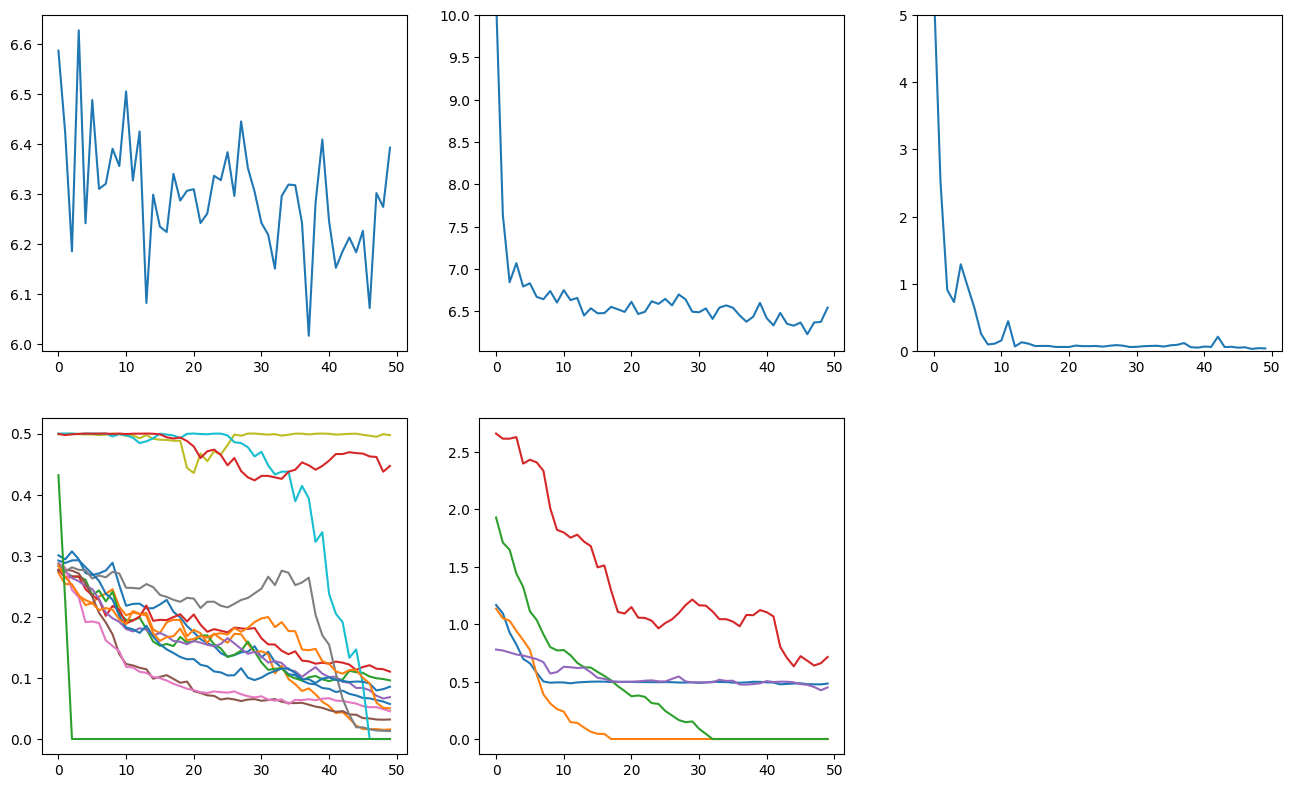

Run 5/5) Current best: 6.393, current mean: 6.545
Test mean
mae: 4.0634, rmse: 5.2169, me: 12.7584
Test std
mae: 0.1054, rmse: 0.1113, me: 0.4300


In [ ]:
df_idx = 1 # dataset 4
current_data_list = nona_list[df_idx]
gs_params = {
    'X': current_data_list[0],
    'y': current_data_list[2],
    'categorical': nona_categorical[df_idx],
    'population_num': 500,
    'mutation_prob': 0.05,
    'sample_size_max': 6,
    'sample_per_object': 5,
    'use_y': False
}
metrics, best_params, run_data = repeat_gs(
    current_data_list, gs_params, runs=5,
    iter_per_run=50, to_plot=True
)

In [ ]:
metric_printer(metrics)

Metrics mean
mae: 4.0092, rmse: 5.2336, me: 12.4064
Metrics std
mae: 0.0477, rmse: 0.0351, me: 0.2136


In [ ]:
param_printer(best_params, list(X_4_nona.columns))

		Parameters
        hyp_num: mean = 7.000, std = 0.000
min_extent_size: mean = 3.200, std = 0.748
   hyp_weighing: mean = 1.600, std = 0.490
  samp_size_low: mean = 0.800, std = 0.400
 samp_size_high: mean = 2.000, std = 0.000



In [ ]:
run_data

[{'err': [np.float64(6.261078261309701),
   np.float64(6.261420259730737),
   np.float64(6.541934178757326),
   np.float64(6.384622917848966),
   np.float64(6.438432382787691),
   np.float64(6.371793051579049),
   np.float64(6.392256096242744),
   np.float64(6.1967307800326425),
   np.float64(6.436701831557326),
   np.float64(6.223917441371439),
   np.float64(6.275018223825283),
   np.float64(6.447861723452638),
   np.float64(6.4476091492173655),
   np.float64(6.383551954770654),
   np.float64(6.328031127701483),
   np.float64(6.248143162903356),
   np.float64(6.480274562021765),
   np.float64(6.281188868066385),
   np.float64(6.21170180357619),
   np.float64(6.369169528864113),
   np.float64(6.139309928388608),
   np.float64(6.3434586182817805),
   np.float64(6.129795805756027),
   np.float64(6.404439094518651),
   np.float64(5.885787185274654),
   np.float64(6.368198543916146),
   np.float64(6.230106903879532),
   np.float64(6.123961110117682),
   np.float64(6.211295318518677),
   np

In [ ]:
metrics

{'mae': {'values': [np.float64(3.920152568529979),
   np.float64(4.012993238993394),
   np.float64(4.021123226960313),
   np.float64(4.028477158114482),
   np.float64(4.0634018077974146)],
  'mean': np.float64(4.0092296000791166),
  'std': np.float64(0.04773978941568851)},
 'rmse': {'values': [np.float64(5.177105444686109),
   np.float64(5.278182667681641),
   np.float64(5.2356184607962515),
   np.float64(5.260229579199063),
   np.float64(5.216939717970315)],
  'mean': np.float64(5.233615174066676),
  'std': np.float64(0.03512839750423628)},
 'me': {'values': [np.float64(12.17430016589981),
   np.float64(12.1924135662627),
   np.float64(12.464357321844219),
   np.float64(12.44265383397124),
   np.float64(12.758351579792702)],
  'mean': np.float64(12.406415293554135),
  'std': np.float64(0.2136369967000226)}}

In [ ]:
best_params

{'hyp_num': {'values': [np.int64(7),
   np.int64(7),
   np.int64(7),
   np.int64(7),
   np.int64(7)],
  'mean': np.float64(7.0),
  'std': np.float64(0.0)},
 'min_extent_size': {'values': [np.int64(3),
   np.int64(3),
   np.int64(4),
   np.int64(2),
   np.int64(4)],
  'mean': np.float64(3.2),
  'std': np.float64(0.7483314773547882)},
 'hyp_weighing': {'values': [np.int64(1),
   np.int64(2),
   np.int64(2),
   np.int64(1),
   np.int64(2)],
  'mean': np.float64(1.6),
  'std': np.float64(0.4898979485566356)},
 'feature_tol': {'values': [array([0.71434503, 0.17819446, 0.6946099 , 0.01580068, 0.66575785,
          0.53757493, 0.70495988, 0.66679927, 0.        , 1.        ,
          0.47071978, 0.68907346, 0.        , 1.        ]),
   array([0.35401636, 0.36056688, 0.76318318, 0.01447882, 0.5218241 ,
          0.75121659, 0.81353469, 0.67253337, 0.        , 1.        ,
          0.34038268, 0.86004551, 0.        , 1.        ]),
   array([0.5867405 , 0.12831669, 0.67959092, 0.        , 0.5723

###### df_4 with no na, 5 times

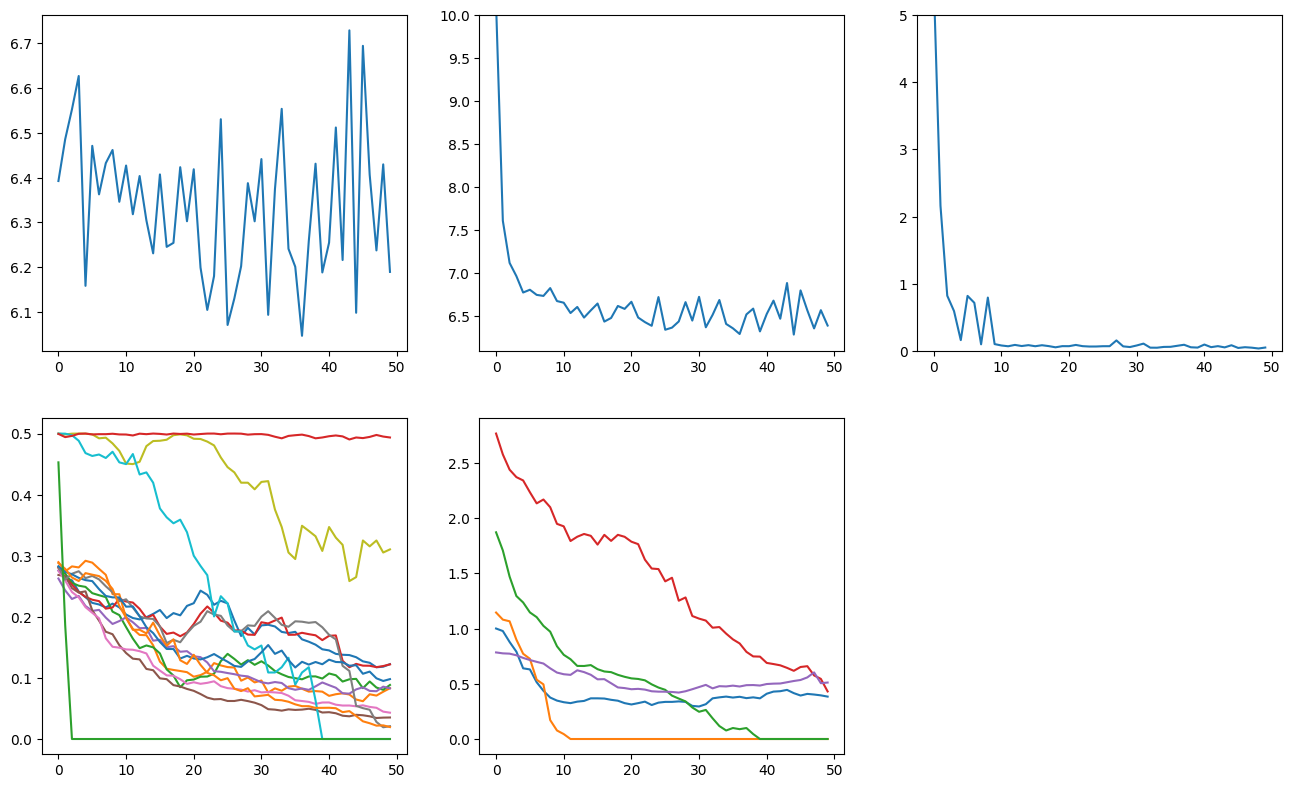

Run 5/5) Current best: 6.189, current mean: 6.389
Test mean
mae: 3.9250, rmse: 5.0928, me: 12.0444
Test std
mae: 0.1218, rmse: 0.1490, me: 0.3267


In [ ]:
df_idx = 1 # dataset 4
current_data_list = nona_list[df_idx]
gs_params = {
    'X': current_data_list[0],
    'y': current_data_list[2],
    'categorical': nona_categorical[df_idx],
    'population_num': 500,
    'mutation_prob': 0.05,
    'sample_size_max': 6,
    'sample_per_object': 5,
    'use_y': True
}
metrics, best_params, run_data = repeat_gs(
    current_data_list, gs_params, runs=5,
    iter_per_run=50, to_plot=True
)

In [ ]:
metric_printer(metrics)

Metrics mean
mae: 4.0023, rmse: 5.1555, me: 12.0889
Metrics std
mae: 0.0600, rmse: 0.0770, me: 0.2956


In [ ]:
param_printer(best_params, list(X_4_nona.columns))

		Parameters
        hyp_num: mean = 7.000, std = 0.000
min_extent_size: mean = 3.400, std = 0.490
   hyp_weighing: mean = 1.800, std = 0.400
  samp_size_low: mean = 0.800, std = 0.400
 samp_size_high: mean = 2.000, std = 0.000



In [ ]:
run_data

[{'err': [np.float64(6.498581206895459),
   np.float64(6.603420559489889),
   np.float64(6.350547344071449),
   np.float64(6.260678741352306),
   np.float64(6.2981725080736455),
   np.float64(6.147816698972396),
   np.float64(6.164977419269938),
   np.float64(6.173236966905792),
   np.float64(6.173457243997104),
   np.float64(6.182387368455682),
   np.float64(6.21692335574705),
   np.float64(6.204213868185431),
   np.float64(6.433301489690336),
   np.float64(6.4981372423282036),
   np.float64(6.333667665227941),
   np.float64(6.115517245055941),
   np.float64(6.253314771993347),
   np.float64(6.1441170189251135),
   np.float64(6.20576315098681),
   np.float64(6.229411490504713),
   np.float64(6.5393071493689305),
   np.float64(6.12635730834374),
   np.float64(6.406108606173197),
   np.float64(5.989139603374749),
   np.float64(6.497111610708155),
   np.float64(6.172638546416165),
   np.float64(6.544761974185922),
   np.float64(6.361855412129413),
   np.float64(6.005913977035567),
   np.

In [ ]:
metrics

{'mae': {'values': [np.float64(4.032326020948284),
   np.float64(3.9561235179803664),
   np.float64(4.000953503066002),
   np.float64(4.097003790942732),
   np.float64(3.9250361411526233)],
  'mean': np.float64(4.002288594818002),
  'std': np.float64(0.05995690741225853)},
 'rmse': {'values': [np.float64(5.1704407472241325),
   np.float64(5.131811980445381),
   np.float64(5.085446656445813),
   np.float64(5.2971408784016765),
   np.float64(5.0928450408862975)],
  'mean': np.float64(5.15553706068066),
  'std': np.float64(0.07704491496474548)},
 'me': {'values': [np.float64(12.638507087033542),
   np.float64(11.896680366111864),
   np.float64(11.779122527998188),
   np.float64(12.085783976206049),
   np.float64(12.044404977533612)],
  'mean': np.float64(12.08889978697665),
  'std': np.float64(0.29562406416182)}}

In [ ]:
best_params

{'hyp_num': {'values': [np.int64(7),
   np.int64(7),
   np.int64(7),
   np.int64(7),
   np.int64(7)],
  'mean': np.float64(7.0),
  'std': np.float64(0.0)},
 'min_extent_size': {'values': [np.int64(3),
   np.int64(4),
   np.int64(3),
   np.int64(3),
   np.int64(4)],
  'mean': np.float64(3.4),
  'std': np.float64(0.4898979485566356)},
 'hyp_weighing': {'values': [np.int64(2),
   np.int64(2),
   np.int64(2),
   np.int64(2),
   np.int64(1)],
  'mean': np.float64(1.8),
  'std': np.float64(0.4)},
 'feature_tol': {'values': [array([0.58698475, 0.12561209, 0.61503734, 0.44767211, 0.58877606,
          0.67536266, 0.86306017, 0.04684335, 0.        , 1.        ,
          0.31430296, 0.70340247, 0.        , 1.        ]),
   array([0.57700127, 0.15256595, 0.73727116, 0.00359053, 0.73993762,
          0.64372688, 0.79670365, 0.60981711, 0.        , 1.        ,
          0.63703589, 0.86453297, 0.        , 1.        ]),
   array([0.48084658, 0.24288379, 0.63330415, 0.02769921, 0.94594516,
         

###### df_4 with na, 5 times

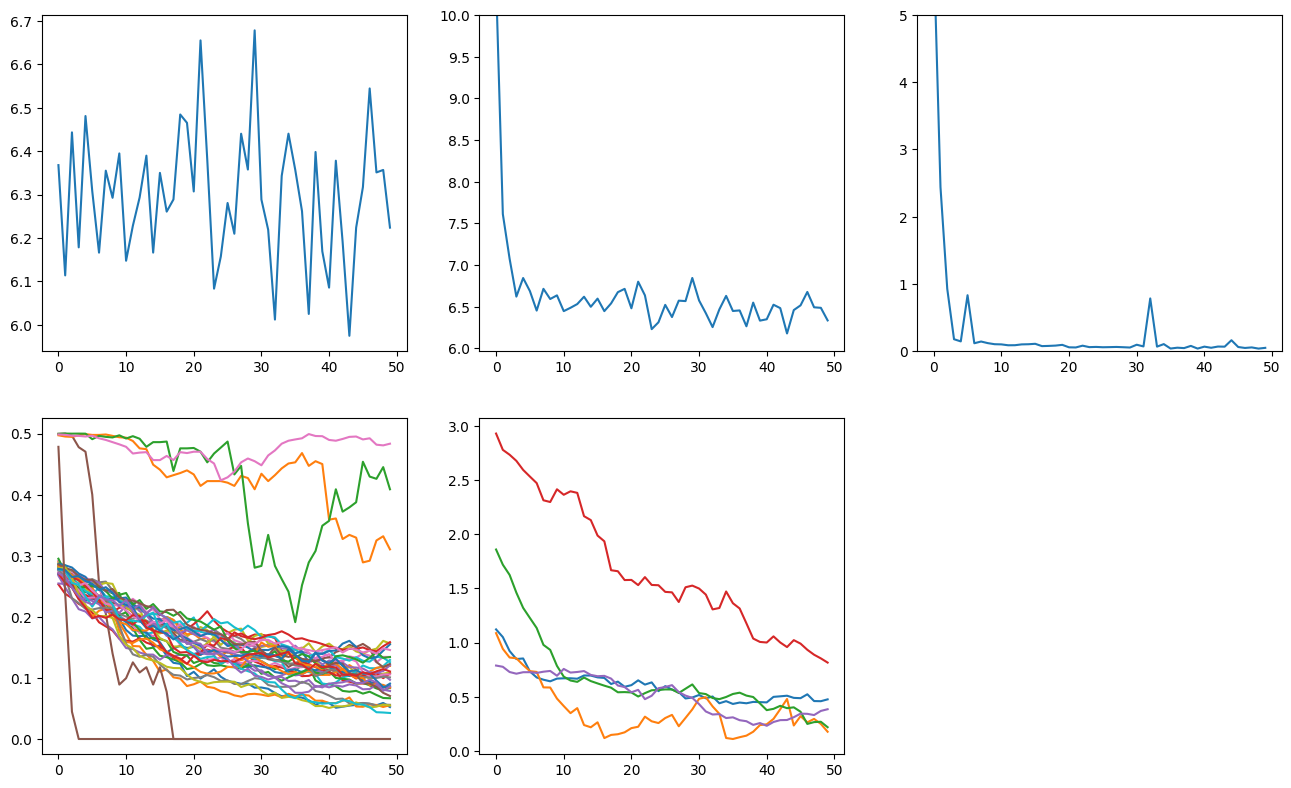

Run 5/5) Current best: 6.224, current mean: 6.336
Test mean
mae: 4.3437, rmse: 5.5537, me: 12.5885
Test std
mae: 0.1528, rmse: 0.1586, me: 0.6150


In [ ]:
df_idx = 1 # dataset 4
current_data_list = na_list[df_idx]
gs_params = {
    'X': current_data_list[0],
    'y': current_data_list[2],
    'categorical': na_categorical[df_idx],
    'population_num': 500,
    'mutation_prob': 0.05,
    'sample_size_max': 6,
    'sample_per_object': 5,
    'use_y': True
}
metrics, best_params, run_data = repeat_gs(
    current_data_list, gs_params, runs=5,
    iter_per_run=50, to_plot=True
)

In [ ]:
run_data

[{'err': [np.float64(6.438931920482668),
   np.float64(6.225160157340369),
   np.float64(6.273902316134349),
   np.float64(6.211949289296912),
   np.float64(6.391567273450845),
   np.float64(6.261873342063803),
   np.float64(6.27290141398133),
   np.float64(6.213918304660807),
   np.float64(6.531329160599607),
   np.float64(6.276552820407636),
   np.float64(6.239023402399835),
   np.float64(6.3695396609305135),
   np.float64(6.462423191520145),
   np.float64(6.05429944756318),
   np.float64(6.189370029182603),
   np.float64(6.153030676808145),
   np.float64(6.214635503593254),
   np.float64(6.112559340445979),
   np.float64(6.025895711586967),
   np.float64(6.110225133965729),
   np.float64(6.090602639322576),
   np.float64(6.4652445099084535),
   np.float64(5.977366495100829),
   np.float64(6.2311266015513),
   np.float64(6.050911302735022),
   np.float64(6.501661945183817),
   np.float64(6.405782204156752),
   np.float64(6.428306835736277),
   np.float64(6.168908796195468),
   np.flo

In [ ]:
metric_printer(metrics)

Metrics mean
mae: 4.2177, rmse: 5.3672, me: 12.0559
Metrics std
mae: 0.1197, rmse: 0.1838, me: 0.5124


In [ ]:
param_printer(best_params, list(X_4.columns))

		Parameters
        hyp_num: mean = 6.400, std = 0.800
min_extent_size: mean = 3.400, std = 1.020
   hyp_weighing: mean = 1.000, std = 0.000
  samp_size_low: mean = 0.600, std = 0.490
 samp_size_high: mean = 2.400, std = 0.490



In [ ]:
metrics

{'mae': {'values': [np.float64(4.065353045659829),
   np.float64(4.267841060853308),
   np.float64(4.083868110808919),
   np.float64(4.327861995250277),
   np.float64(4.343685269084762)],
  'mean': np.float64(4.217721896331419),
  'std': np.float64(0.11970183446489907)},
 'rmse': {'values': [np.float64(5.132669259932381),
   np.float64(5.420364491298493),
   np.float64(5.1692436201314305),
   np.float64(5.559892877502242),
   np.float64(5.553651946174092)],
  'mean': np.float64(5.367164439007728),
  'std': np.float64(0.18380028642613244)},
 'me': {'values': [np.float64(11.38699001900241),
   np.float64(12.103713760214738),
   np.float64(11.563852031861382),
   np.float64(12.636531197761288),
   np.float64(12.58850965828479)],
  'mean': np.float64(12.05591933342492),
  'std': np.float64(0.5123755566645339)}}

In [ ]:
best_params

{'hyp_num': {'values': [np.int64(6),
   np.int64(5),
   np.int64(7),
   np.int64(7),
   np.int64(7)],
  'mean': np.float64(6.4),
  'std': np.float64(0.7999999999999999)},
 'min_extent_size': {'values': [np.int64(3),
   np.int64(3),
   np.int64(2),
   np.int64(5),
   np.int64(4)],
  'mean': np.float64(3.4),
  'std': np.float64(1.019803902718557)},
 'hyp_weighing': {'values': [np.int64(1),
   np.int64(1),
   np.int64(1),
   np.int64(1),
   np.int64(1)],
  'mean': np.float64(1.0),
  'std': np.float64(0.0)},
 'feature_tol': {'values': [array([0.75294688, 0.66160528, 0.69945268, 0.41016833, 0.53345657,
          0.        , 0.49689058, 0.62873489, 0.59432078, 0.32946964,
          0.472493  , 0.61081471, 0.6946842 , 0.6447803 , 0.75269056,
          0.37964934, 0.50089777, 0.48103685, 0.63788507, 0.59482064,
          0.45212357, 0.70533713, 0.20889724, 0.29765206, 0.28986119,
          0.55538905, 0.90432776, 0.72201917, 0.86850387, 0.91739773,
          0.31432606, 0.        , 1.        ,

###### df_4 with na, 5 times, use_y=False

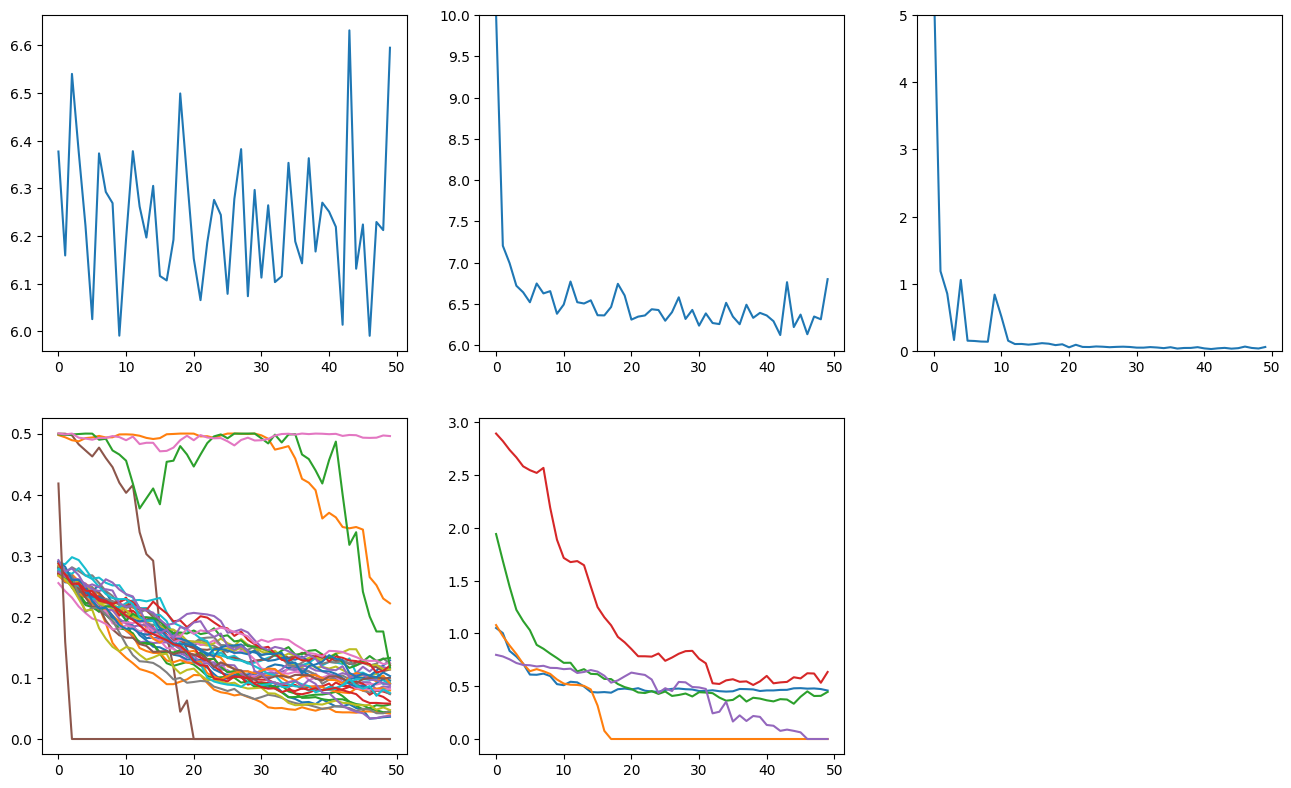

Run 5/5) Current best: 6.595, current mean: 6.799
Test mean
mae: 4.0658, rmse: 5.1406, me: 11.6055
Test std
mae: 0.1463, rmse: 0.1730, me: 0.6776


In [ ]:
df_idx = 1 # dataset 4
current_data_list = na_list[df_idx]
gs_params = {
    'X': current_data_list[0],
    'y': current_data_list[2],
    'categorical': na_categorical[df_idx],
    'population_num': 500,
    'mutation_prob': 0.05,
    'sample_size_max': 6,
    'sample_per_object': 5,
    'use_y': False
}
metrics, best_params, run_data = repeat_gs(
    current_data_list, gs_params, runs=5,
    iter_per_run=50, to_plot=True
)

In [ ]:
metric_printer(metrics)

Metrics mean
mae: 4.1613, rmse: 5.2655, me: 11.7544
Metrics std
mae: 0.1083, rmse: 0.1576, me: 0.3358


In [ ]:
param_printer(best_params, list(X_4.columns))

		Parameters
        hyp_num: mean = 6.600, std = 0.490
min_extent_size: mean = 2.800, std = 1.327
   hyp_weighing: mean = 1.000, std = 0.894
  samp_size_low: mean = 0.600, std = 0.490
 samp_size_high: mean = 2.000, std = 0.000



In [ ]:
metrics

{'mae': {'values': [np.float64(4.371390712069055),
   np.float64(4.146543485548644),
   np.float64(4.101166287716357),
   np.float64(4.121800290031671),
   np.float64(4.0657934666729325)],
  'mean': np.float64(4.161338848407732),
  'std': np.float64(0.10830848795841455)},
 'rmse': {'values': [np.float64(5.5622383111925044),
   np.float64(5.136864144580179),
   np.float64(5.204581085554261),
   np.float64(5.283289976962193),
   np.float64(5.140639876313404)],
  'mean': np.float64(5.265522678920508),
  'std': np.float64(0.15761881484257909)},
 'me': {'values': [np.float64(12.162468644617185),
   np.float64(11.189022599906039),
   np.float64(11.842040846903409),
   np.float64(11.972939035309572),
   np.float64(11.605460348232661)],
  'mean': np.float64(11.754386294993774),
  'std': np.float64(0.33579603040719186)}}

In [ ]:
best_params

{'hyp_num': {'values': [np.int64(6),
   np.int64(7),
   np.int64(6),
   np.int64(7),
   np.int64(7)],
  'mean': np.float64(6.6),
  'std': np.float64(0.48989794855663565)},
 'min_extent_size': {'values': [np.int64(3),
   np.int64(1),
   np.int64(3),
   np.int64(2),
   np.int64(5)],
  'mean': np.float64(2.8),
  'std': np.float64(1.32664991614216)},
 'hyp_weighing': {'values': [np.int64(1),
   np.int64(2),
   np.int64(0),
   np.int64(2),
   np.int64(0)],
  'mean': np.float64(1.0),
  'std': np.float64(0.8944271909999159)},
 'feature_tol': {'values': [array([0.54131247, 0.7893033 , 0.79353419, 0.39234992, 0.59159341,
          0.        , 0.65921068, 0.49472044, 0.61143627, 0.51611951,
          0.54317698, 0.42164191, 0.61302483, 0.32037183, 0.45286973,
          0.6633306 , 0.53250741, 0.43971349, 0.45693297, 0.6003549 ,
          0.59047743, 0.38524833, 0.57357075, 0.51579369, 0.45659547,
          0.73310219, 0.44060676, 0.71113036, 0.7414648 , 0.33377582,
          0.61805133, 0.      

In [ ]:
run_data

[{'err': [np.float64(6.264007681417431),
   np.float64(6.44284374635896),
   np.float64(6.391693378329703),
   np.float64(6.343579188616687),
   np.float64(6.418492736394145),
   np.float64(6.402290683064296),
   np.float64(6.77319306503324),
   np.float64(6.373708253589442),
   np.float64(6.261866703329223),
   np.float64(6.390130852648188),
   np.float64(6.379314134009135),
   np.float64(6.171995698807988),
   np.float64(6.228692451898736),
   np.float64(6.329183691425233),
   np.float64(6.171445138680165),
   np.float64(6.349330272306494),
   np.float64(6.23880095955249),
   np.float64(6.246861943584323),
   np.float64(6.539548407891078),
   np.float64(6.531430456600018),
   np.float64(6.208368321878393),
   np.float64(6.423394770386052),
   np.float64(6.094109759347952),
   np.float64(6.378041425653237),
   np.float64(6.314445999542684),
   np.float64(6.248269435801437),
   np.float64(6.457221585939846),
   np.float64(6.372213974626904),
   np.float64(6.510051588992168),
   np.floa

##### DF 5

###### df_5 with no na, 5 times, use_y=False

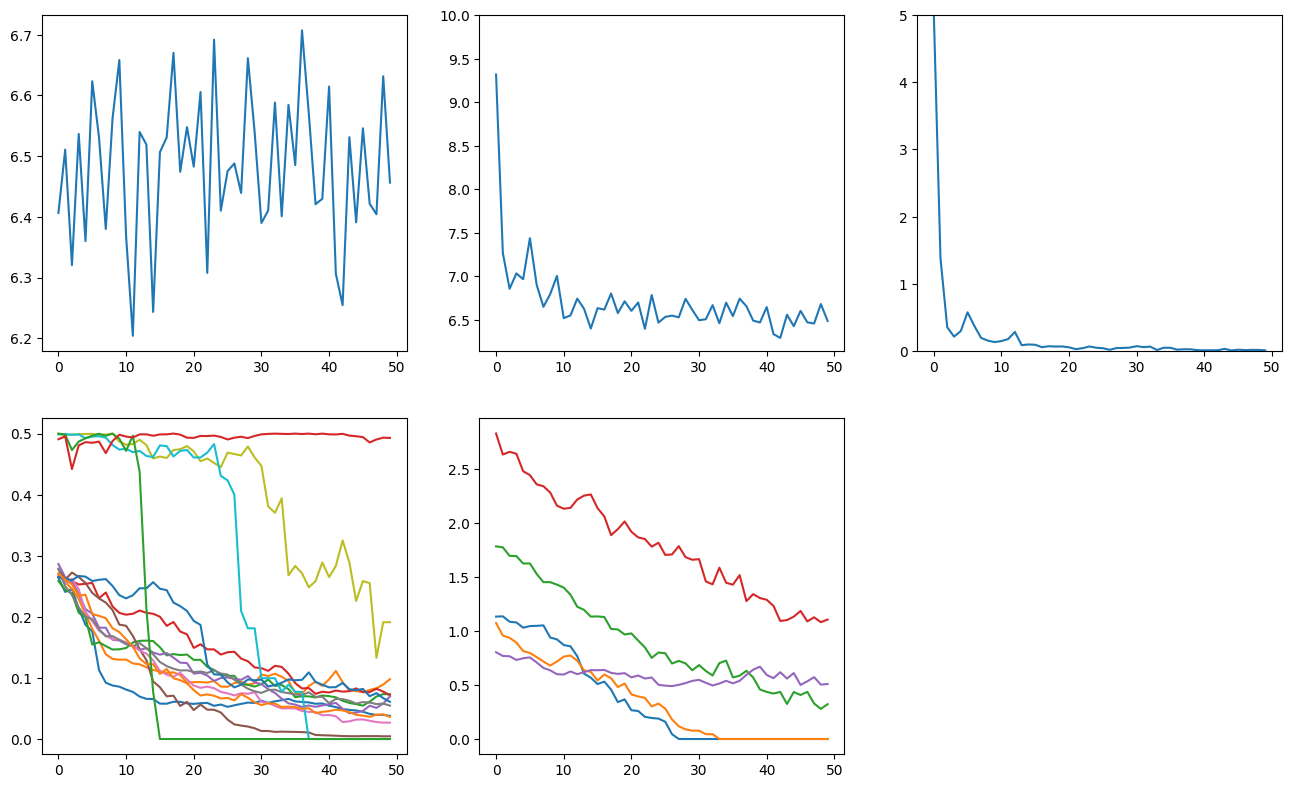

Run 5/5) Current best: 6.456, current mean: 6.489
Test mean
mae: 9.1472, rmse: 11.6239, me: 19.3164
Test std
mae: 0.0247, rmse: 0.0615, me: 0.1909


In [ ]:
df_idx = 2 # dataset 5
current_data_list = nona_list[df_idx]
gs_params = {
    'X': current_data_list[0],
    'y': current_data_list[2],
    'categorical': nona_categorical[df_idx],
    'population_num': 500,
    'mutation_prob': 0.05,
    'sample_size_max':6,
    'sample_per_object': 5,
    'use_y': False
}
metrics, best_params, run_data = repeat_gs(
    current_data_list, gs_params, runs=5,
    iter_per_run=50, to_plot=True
)

In [ ]:
run_data

[{'err': [np.float64(6.62967346902712),
   np.float64(6.381925552956008),
   np.float64(6.507767705121448),
   np.float64(6.695990659120656),
   np.float64(6.5387577261328715),
   np.float64(6.022064879315641),
   np.float64(6.307480022201802),
   np.float64(6.680604619301458),
   np.float64(6.377960931857786),
   np.float64(6.065698434464177),
   np.float64(6.495038654443839),
   np.float64(6.510397646534379),
   np.float64(6.553805100120668),
   np.float64(6.410479016427897),
   np.float64(6.191505512124288),
   np.float64(6.375087455804783),
   np.float64(6.292782945761781),
   np.float64(6.286411028781593),
   np.float64(6.43655983639276),
   np.float64(6.471437874902061),
   np.float64(6.68245909204451),
   np.float64(6.6278732282248),
   np.float64(6.729393828347331),
   np.float64(6.431647911143915),
   np.float64(6.494742154636958),
   np.float64(6.36319339651096),
   np.float64(6.447578944023226),
   np.float64(6.38917726051392),
   np.float64(6.619992965175965),
   np.float64

In [ ]:
metric_printer(metrics)

Metrics mean
mae: 9.1442, rmse: 11.6340, me: 19.4599
Metrics std
mae: 0.0259, rmse: 0.0367, me: 0.3714


In [ ]:
param_printer(best_params, list(X_5_nona.columns))

		Parameters
        hyp_num: mean = 5.400, std = 0.490
min_extent_size: mean = 4.800, std = 1.939
   hyp_weighing: mean = 1.200, std = 0.980
  samp_size_low: mean = 3.000, std = 0.000
 samp_size_high: mean = 4.000, std = 0.000



In [ ]:
metrics

{'mae': {'values': [np.float64(9.149883193587915),
   np.float64(9.101983320888793),
   np.float64(9.138965056032765),
   np.float64(9.182947731560974),
   np.float64(9.147157675217857)],
  'mean': np.float64(9.14418739545766),
  'std': np.float64(0.025892412295186296)},
 'rmse': {'values': [np.float64(11.677165186679115),
   np.float64(11.655293070594404),
   np.float64(11.644375864920814),
   np.float64(11.569254015985111),
   np.float64(11.623894482900901)],
  'mean': np.float64(11.63399652421607),
  'std': np.float64(0.036656379064842676)},
 'me': {'values': [np.float64(19.963563006937804),
   np.float64(19.790364706090415),
   np.float64(19.29863522058472),
   np.float64(18.930526539312446),
   np.float64(19.31641026693814)],
  'mean': np.float64(19.459899947972705),
  'std': np.float64(0.37140684969003507)}}

In [ ]:
best_params

{'hyp_num': {'values': [np.int64(5),
   np.int64(6),
   np.int64(6),
   np.int64(5),
   np.int64(5)],
  'mean': np.float64(5.4),
  'std': np.float64(0.48989794855663565)},
 'min_extent_size': {'values': [np.int64(6),
   np.int64(6),
   np.int64(6),
   np.int64(1),
   np.int64(5)],
  'mean': np.float64(4.8),
  'std': np.float64(1.9390719429665317)},
 'hyp_weighing': {'values': [np.int64(0),
   np.int64(2),
   np.int64(0),
   np.int64(2),
   np.int64(2)],
  'mean': np.float64(1.2),
  'std': np.float64(0.9797958971132713)},
 'feature_tol': {'values': [array([0.89405385, 0.80489211, 0.7663084 , 0.90867674, 0.58977333,
          0.14552618, 0.72380612, 0.70153789, 1.        , 1.        ,
          0.39295944, 0.77956461, 0.        , 0.        ]),
   array([0.82738856, 0.74185925, 0.54676884, 0.49630897, 0.64000377,
          0.11740536, 0.80674033, 0.71341431, 1.        , 1.        ,
          0.43827468, 0.70717902, 0.        , 0.        ]),
   array([0.92822781, 0.67629737, 0.77808773, 0.

###### df_5 with na, 5 times

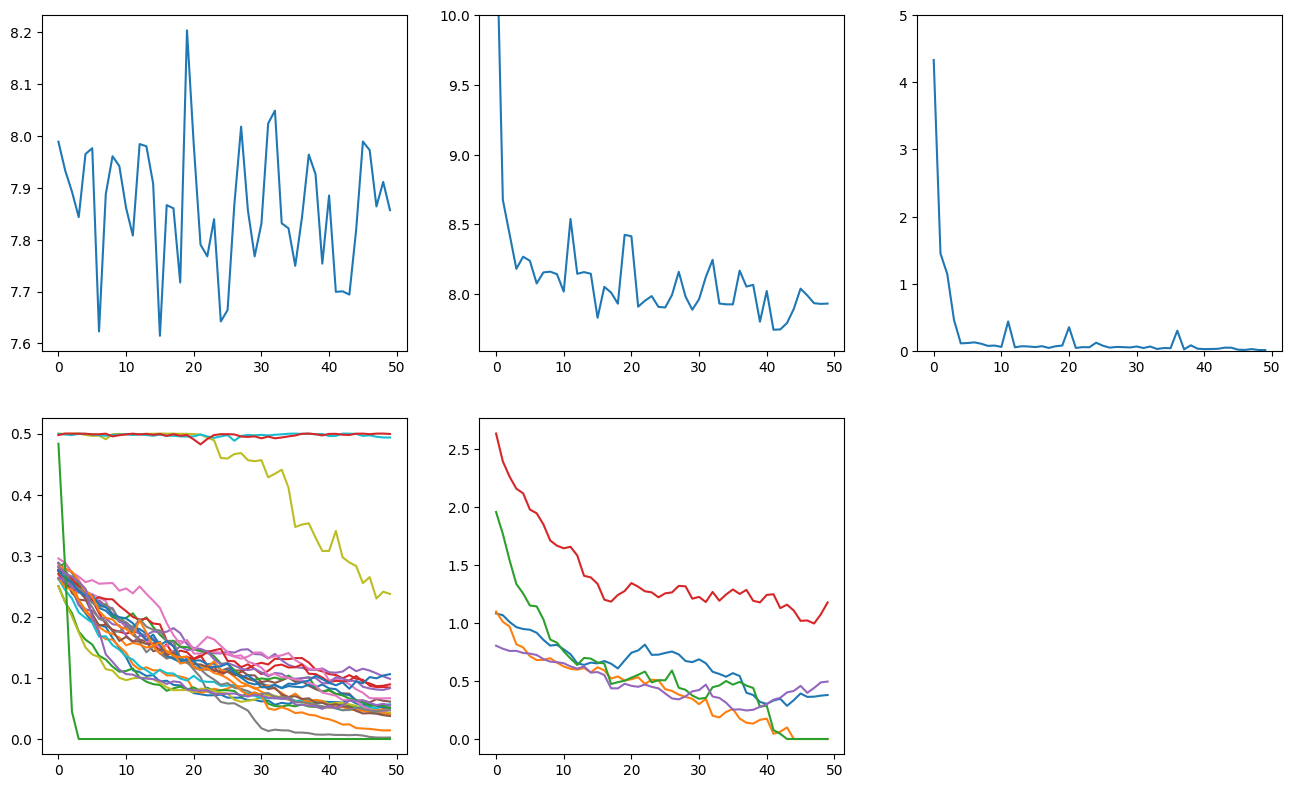

Run 5/5) Current best: 7.857, current mean: 7.933
Test mean
mae: 5.4606, rmse: 7.5869, me: 18.6758
Test std
mae: 0.0117, rmse: 0.0166, me: 0.2064


In [ ]:
df_idx = 2 # dataset 5
current_data_list = na_list[df_idx]
gs_params = {
    'X': current_data_list[0],
    'y': current_data_list[2],
    'categorical': na_categorical[df_idx],
    'population_num': 500,
    'mutation_prob': 0.05,
    'sample_size_max': 6,
    'sample_per_object': 5,
    'use_y': True
}
metrics, best_params, run_data = repeat_gs(
    current_data_list, gs_params, runs=5,
    iter_per_run=50, to_plot=True
)

In [ ]:
metric_printer(metrics)

Metrics mean
mae: 5.5150, rmse: 7.6291, me: 18.5639
Metrics std
mae: 0.0484, rmse: 0.0404, me: 0.0937


In [ ]:
param_printer(best_params, list(X_5.columns))

		Parameters
        hyp_num: mean = 3.800, std = 0.748
min_extent_size: mean = 7.600, std = 2.245
   hyp_weighing: mean = 1.000, std = 0.632
  samp_size_low: mean = 0.600, std = 0.490
 samp_size_high: mean = 4.600, std = 0.800



In [ ]:
run_data

[{'err': [np.float64(7.7695391079401315),
   np.float64(7.828458608375729),
   np.float64(7.8610079833739945),
   np.float64(7.8402789352786995),
   np.float64(7.844421839066717),
   np.float64(8.090744460735461),
   np.float64(7.809540202611416),
   np.float64(7.371569865226434),
   np.float64(8.007008385257338),
   np.float64(7.924158708135957),
   np.float64(7.719876787574684),
   np.float64(7.724042901178971),
   np.float64(7.682281856536932),
   np.float64(7.697072083349073),
   np.float64(7.940357859890796),
   np.float64(7.936154300650861),
   np.float64(7.916656189764922),
   np.float64(8.017386488905775),
   np.float64(7.7586030078886905),
   np.float64(7.88985129937704),
   np.float64(7.8031240450226464),
   np.float64(7.782063158947649),
   np.float64(7.759637585123349),
   np.float64(7.844215374489165),
   np.float64(8.069492445079723),
   np.float64(7.818712181180443),
   np.float64(8.151533512185846),
   np.float64(7.850287900266373),
   np.float64(7.761378928042079),
   

In [ ]:
metrics

{'mae': {'values': [np.float64(5.508064670063107),
   np.float64(5.465398834989888),
   np.float64(5.564156983450285),
   np.float64(5.577029194121484),
   np.float64(5.460562859500561)],
  'mean': np.float64(5.515042508425064),
  'std': np.float64(0.04844749229405151)},
 'rmse': {'values': [np.float64(7.621028654407189),
   np.float64(7.586851710149374),
   np.float64(7.663885628671616),
   np.float64(7.686603342467804),
   np.float64(7.586894652496242)],
  'mean': np.float64(7.629052797638446),
  'std': np.float64(0.040368351934723525)},
 'me': {'values': [np.float64(18.394375373465472),
   np.float64(18.61360501876764),
   np.float64(18.560507647995646),
   np.float64(18.575017255968383),
   np.float64(18.67576641808302)],
  'mean': np.float64(18.56385434285603),
  'std': np.float64(0.09365722011313518)}}

In [ ]:
best_params

{'hyp_num': {'values': [np.int64(5),
   np.int64(3),
   np.int64(4),
   np.int64(4),
   np.int64(3)],
  'mean': np.float64(3.8),
  'std': np.float64(0.7483314773547882)},
 'min_extent_size': {'values': [np.int64(10),
   np.int64(9),
   np.int64(9),
   np.int64(6),
   np.int64(4)],
  'mean': np.float64(7.6),
  'std': np.float64(2.244994432064365)},
 'hyp_weighing': {'values': [np.int64(0),
   np.int64(1),
   np.int64(1),
   np.int64(1),
   np.int64(2)],
  'mean': np.float64(1.0),
  'std': np.float64(0.6324555320336759)},
 'feature_tol': {'values': [array([0.78722888, 0.76825852, 0.69588741, 0.62424171, 0.61537299,
          0.3268681 , 0.35939431, 0.50888287, 0.80525385, 0.77456022,
          0.74572789, 0.54181727, 0.50781263, 0.11863441, 0.57418879,
          0.58013035, 0.34375564, 0.72828874, 1.        , 0.        ,
          0.62481461, 0.46821759, 0.        , 0.        , 0.4836354 ]),
   array([0.81574748, 0.7109273 , 0.68667751, 0.63210767, 0.6392478 ,
          0.49573403, 0.462

early stop

In [ ]:
param_printer(best_params, list(X_5.columns)) #3rd is good

		Parameters
        hyp_num: mean = 5.667, std = 1.247
min_extent_size: mean = 7.667, std = 0.943
   hyp_weighing: mean = 0.333, std = 0.471
  samp_size_low: mean = 1.000, std = 0.000
 samp_size_high: mean = 2.667, std = 0.943



In [ ]:
params = {}
for key in best_params:
    params[key] = best_params[key]['mean']
    if 'feature_tol' not in key:
        params[key] = int(np.round(params[key]))

test_fca(
    params, data_list=current_data_list,
    categorical=gs_params['categorical'],
    sample_size_max=gs_params['sample_size_max'],
    sample_per_object=gs_params['sample_per_object'],
    use_y=gs_params['use_y'], times=100
)

Test mean
mae: 5.5277, rmse: 7.5477, me: 18.1792
Test std
mae: 0.0731, rmse: 0.0985, me: 0.4278


(np.float64(5.527665830794707),
 np.float64(7.54765010253271),
 np.float64(18.17924731088305))

In [ ]:
run_data

[{'err': [np.float64(8.218497525763224), np.float64(7.952441183719611)],
  'params': [{'hyp_num': np.int64(3),
    'min_extent_size': np.int64(6),
    'hyp_weighing': np.int64(1),
    'feature_tol': array([0.77927415, 0.84568507, 0.83991182, 0.57261447, 0.26073208,
           0.81779506, 0.51640318, 0.70242266, 0.8696911 , 0.57139188,
           0.96941983, 0.48647206, 0.92218829, 0.28189288, 0.96416216,
           0.68416496, 0.57598637, 0.21823203, 0.        , 1.        ,
           0.11611107, 0.02666396, 0.        , 0.        , 0.55139991]),
    'samp_size_low': np.int64(0),
    'samp_size_high': np.int64(5)},
   {'hyp_num': np.int64(6),
    'min_extent_size': np.int64(9),
    'hyp_weighing': np.int64(0),
    'feature_tol': array([0.16814168, 0.75523097, 0.40764279, 0.65650103, 0.36588374,
           0.27559144, 0.58611879, 0.61494985, 0.10873097, 0.62399229,
           0.75314656, 0.30865909, 0.15627265, 0.41493548, 0.41663972,
           0.90204458, 0.79411206, 0.08982972, 0.    

In [ ]:
metrics

{'mae': {'values': [np.float64(6.512885436533647),
   np.float64(5.849447716310888),
   np.float64(5.511420089558665)],
  'mean': np.float64(5.957917747467733),
  'std': np.float64(0.4159787823453706)},
 'rmse': {'values': [np.float64(8.413333020715884),
   np.float64(7.924846847728756),
   np.float64(7.0422459948208)],
  'mean': np.float64(7.793475287755147),
  'std': np.float64(0.5673997845269718)},
 'me': {'values': [np.float64(20.031822627697046),
   np.float64(19.803528320123565),
   np.float64(18.129220370646784)],
  'mean': np.float64(19.321523772822466),
  'std': np.float64(0.8482217182032031)}}

In [ ]:
best_params

{'hyp_num': {'values': [np.int64(6), np.int64(4), np.int64(7)],
  'mean': np.float64(5.666666666666667),
  'std': np.float64(1.247219128924647)},
 'min_extent_size': {'values': [np.int64(9), np.int64(7), np.int64(7)],
  'mean': np.float64(7.666666666666667),
  'std': np.float64(0.9428090415820634)},
 'hyp_weighing': {'values': [np.int64(0), np.int64(1), np.int64(0)],
  'mean': np.float64(0.3333333333333333),
  'std': np.float64(0.4714045207910317)},
 'feature_tol': {'values': [array([0.16814168, 0.75523097, 0.40764279, 0.65650103, 0.36588374,
          0.27559144, 0.58611879, 0.61494985, 0.10873097, 0.62399229,
          0.75314656, 0.30865909, 0.15627265, 0.41493548, 0.41663972,
          0.90204458, 0.79411206, 0.08982972, 0.        , 1.        ,
          0.65194205, 0.12123066, 0.        , 1.        , 0.90299821]),
   array([0.73544182, 0.92969218, 0.51938651, 0.71486369, 0.29290652,
          0.26714986, 0.6112144 , 0.86204324, 0.48627617, 0.47329633,
          0.93028394, 0.01671

###### df_5 with na, 5 times, use_y=False

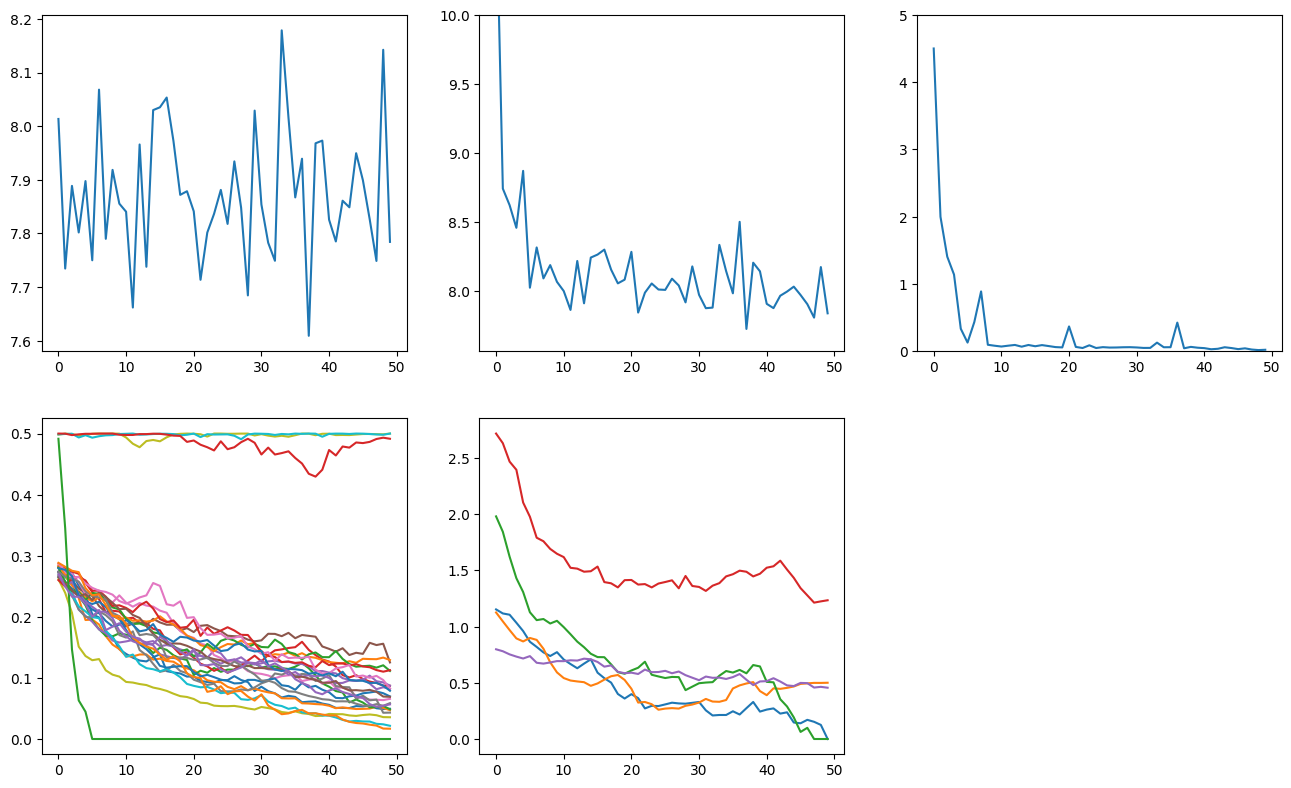

Run 5/5) Current best: 7.784, current mean: 7.842
Test mean
mae: 5.4825, rmse: 7.5978, me: 18.5527
Test std
mae: 0.0647, rmse: 0.0439, me: 0.0777


In [ ]:
df_idx = 2 # dataset 5
current_data_list = na_list[df_idx]
gs_params = {
    'X': current_data_list[0],
    'y': current_data_list[2],
    'categorical': na_categorical[df_idx],
    'population_num': 500,
    'mutation_prob': 0.05,
    'sample_size_max': 6,
    'sample_per_object': 5,
    'use_y': False
}
metrics, best_params, run_data = repeat_gs(
    current_data_list, gs_params, runs=5,
    iter_per_run=50, to_plot=True
)

In [ ]:
metric_printer(metrics)

Metrics mean
mae: 5.4978, rmse: 7.6225, me: 18.5808
Metrics std
mae: 0.0479, rmse: 0.0520, me: 0.0649


In [ ]:
param_printer(best_params, list(X_5.columns))

		Parameters
        hyp_num: mean = 3.200, std = 0.400
min_extent_size: mean = 6.200, std = 0.748
   hyp_weighing: mean = 1.400, std = 0.490
  samp_size_low: mean = 2.000, std = 0.000
 samp_size_high: mean = 4.400, std = 0.490



In [ ]:
params = {}
for key in best_params:
    params[key] = best_params[key]['mean']
    if 'feature_tol' not in key:
        params[key] = int(np.round(params[key]))

test_fca(
    params, data_list=current_data_list,
    categorical=gs_params['categorical'],
    sample_size_max=gs_params['sample_size_max'],
    sample_per_object=gs_params['sample_per_object'],
    use_y=gs_params['use_y'], times=100
)

Test mean
mae: 5.4910, rmse: 7.5897, me: 18.3833
Test std
mae: 0.0203, rmse: 0.0430, me: 0.1618


(np.float64(5.490953825956452),
 np.float64(7.589708587681862),
 np.float64(18.38326648041452))

In [ ]:
run_data

[{'err': [np.float64(7.859561403288883),
   np.float64(7.664597680182117),
   np.float64(7.859669718442487),
   np.float64(8.02712760988056),
   np.float64(7.804091283991497),
   np.float64(7.743416073437961),
   np.float64(7.704530048864432),
   np.float64(7.923169836806238),
   np.float64(7.779057082177959),
   np.float64(7.784404203892737),
   np.float64(7.763443002091658),
   np.float64(7.873766787331474),
   np.float64(7.866979622640524),
   np.float64(7.776723968425911),
   np.float64(7.8184870144864345),
   np.float64(7.777226502466343),
   np.float64(7.964391822928496),
   np.float64(7.864618873981601),
   np.float64(7.818654813900719),
   np.float64(7.796124767430849),
   np.float64(7.874352771697781),
   np.float64(7.9470767094304335),
   np.float64(7.753393072879898),
   np.float64(7.916774130439526),
   np.float64(7.812747479231552),
   np.float64(8.115282379151324),
   np.float64(7.854950227658041),
   np.float64(7.821274520061165),
   np.float64(7.940364080231471),
   np.

In [ ]:
metrics

{'mae': {'values': [np.float64(5.484477903180633),
   np.float64(5.470102241139552),
   np.float64(5.459946612411334),
   np.float64(5.591924751942708),
   np.float64(5.48246115285756)],
  'mean': np.float64(5.497782532306357),
  'std': np.float64(0.04790046074063948)},
 'rmse': {'values': [np.float64(7.596752958132091),
   np.float64(7.597412533594728),
   np.float64(7.593836008622755),
   np.float64(7.726458134996851),
   np.float64(7.597796344912904)],
  'mean': np.float64(7.622451196051865),
  'std': np.float64(0.05202204923840888)},
 'me': {'values': [np.float64(18.478814128764608),
   np.float64(18.597952716925906),
   np.float64(18.59736040945148),
   np.float64(18.677236475579935),
   np.float64(18.552715627593365)],
  'mean': np.float64(18.58081587166306),
  'std': np.float64(0.0648973116962305)}}

In [ ]:
best_params

{'hyp_num': {'values': [np.int64(3),
   np.int64(3),
   np.int64(3),
   np.int64(4),
   np.int64(3)],
  'mean': np.float64(3.2),
  'std': np.float64(0.39999999999999997)},
 'min_extent_size': {'values': [np.int64(5),
   np.int64(6),
   np.int64(7),
   np.int64(6),
   np.int64(7)],
  'mean': np.float64(6.2),
  'std': np.float64(0.7483314773547882)},
 'hyp_weighing': {'values': [np.int64(1),
   np.int64(2),
   np.int64(2),
   np.int64(1),
   np.int64(1)],
  'mean': np.float64(1.4),
  'std': np.float64(0.4898979485566356)},
 'feature_tol': {'values': [array([0.7806599 , 0.63323265, 0.58795089, 0.54029513, 0.41339176,
          0.325743  , 0.45912689, 0.46198011, 0.82910781, 0.32380529,
          0.64040557, 0.58576686, 0.561557  , 0.6303964 , 0.50700214,
          0.70179295, 0.31464445, 0.68406124, 1.        , 0.        ,
          0.34946765, 0.57415362, 0.        , 0.        , 0.70397728]),
   array([0.81725322, 0.71899707, 0.84712823, 0.51918508, 0.57752576,
          0.61608992, 0.44

###### df_5 with no na, 5 times

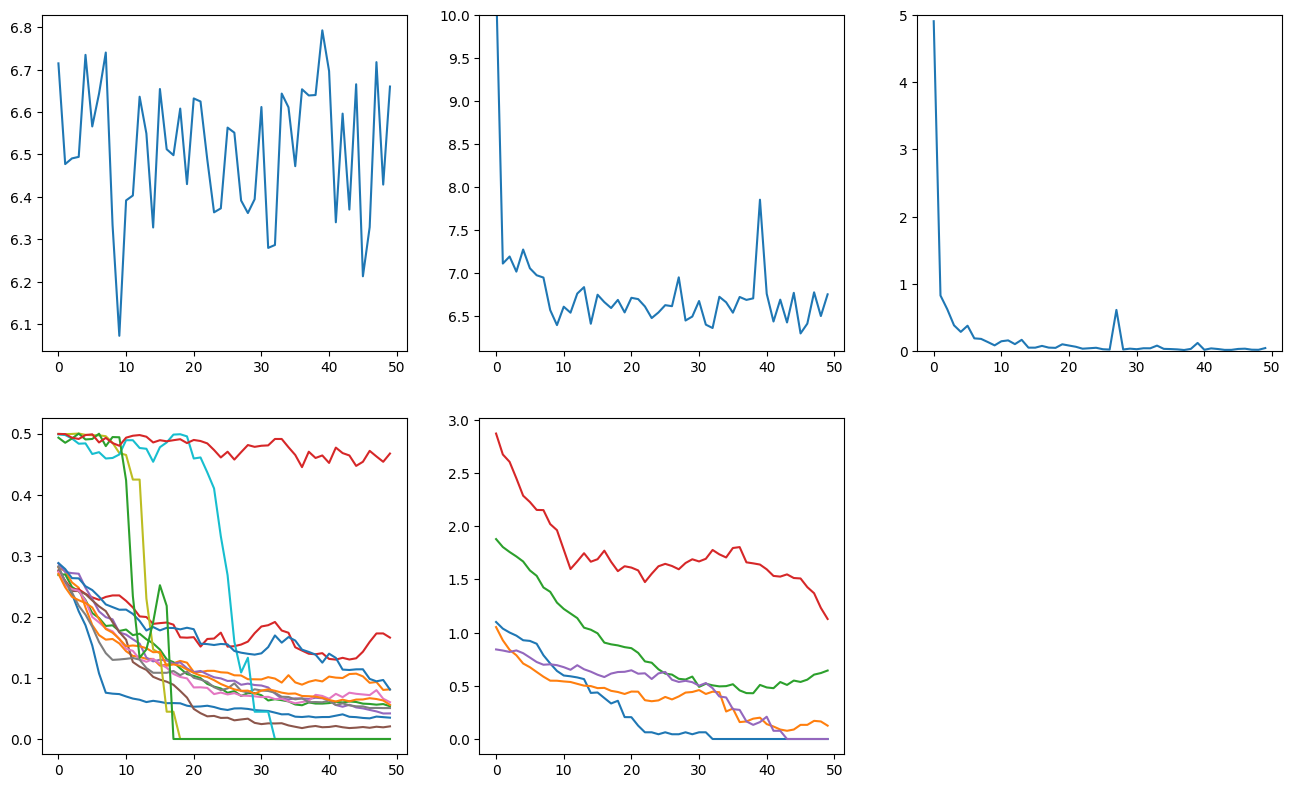

Run 5/5) Current best: 6.660, current mean: 6.750
Test mean
mae: 9.1772, rmse: 11.4904, me: 18.7664
Test std
mae: 0.0544, rmse: 0.0639, me: 0.2673


In [ ]:
df_idx = 2 # dataset 5
current_data_list = nona_list[df_idx]
gs_params = {
    'X': current_data_list[0],
    'y': current_data_list[2],
    'categorical': nona_categorical[df_idx],
    'population_num': 500,
    'mutation_prob': 0.05,
    'sample_size_max':6,
    'sample_per_object': 5,
    'use_y': True
}
metrics, best_params, run_data = repeat_gs(
    current_data_list, gs_params, runs=5,
    iter_per_run=50, to_plot=True
)

In [ ]:
run_data

[{'err': [np.float64(6.519234702795766),
   np.float64(6.6685131949876535),
   np.float64(6.543480583869266),
   np.float64(6.3664565069316525),
   np.float64(6.616850732080553),
   np.float64(6.578421388858102),
   np.float64(6.239282714312958),
   np.float64(6.63668352512876),
   np.float64(6.195321133407691),
   np.float64(6.5231516792617725),
   np.float64(6.585487980883952),
   np.float64(6.276313733079775),
   np.float64(6.437019520457217),
   np.float64(6.36467527825131),
   np.float64(6.589912686686378),
   np.float64(6.509774085880937),
   np.float64(6.593334223375239),
   np.float64(6.503199971220136),
   np.float64(6.396171025545978),
   np.float64(6.7157840764516),
   np.float64(6.580456530932094),
   np.float64(6.365244686505581),
   np.float64(6.534819497463492),
   np.float64(6.376857061420283),
   np.float64(6.318910306150956),
   np.float64(6.390578950653452),
   np.float64(6.558444156719647),
   np.float64(6.645644468362467),
   np.float64(6.5137942532448365),
   np.f

In [ ]:
metric_printer(metrics)

Metrics mean
mae: 9.1460, rmse: 11.5564, me: 19.1426
Metrics std
mae: 0.0221, rmse: 0.0568, me: 0.2788


In [ ]:
param_printer(best_params, list(X_5_nona.columns))

		Parameters
        hyp_num: mean = 5.600, std = 0.490
min_extent_size: mean = 6.200, std = 0.980
   hyp_weighing: mean = 0.600, std = 0.800
  samp_size_low: mean = 3.000, std = 0.632
 samp_size_high: mean = 4.600, std = 0.490



In [ ]:
metrics

{'mae': {'values': [np.float64(9.154249645151918),
   np.float64(9.123724959927317),
   np.float64(9.15683769664429),
   np.float64(9.11793516086522),
   np.float64(9.177196696507657)],
  'mean': np.float64(9.145988831819281),
  'std': np.float64(0.02210229928734311)},
 'rmse': {'values': [np.float64(11.628938385036562),
   np.float64(11.563524982854686),
   np.float64(11.493037796583922),
   np.float64(11.606087988528348),
   np.float64(11.490407867744668)],
  'mean': np.float64(11.556399404149635),
  'std': np.float64(0.05683521659667681)},
 'me': {'values': [np.float64(19.569330965950254),
   np.float64(19.08621906717891),
   np.float64(18.969747261923725),
   np.float64(19.321489738052655),
   np.float64(18.766357428289638)],
  'mean': np.float64(19.14262889227904),
  'std': np.float64(0.27882474887320674)}}

In [ ]:
best_params

{'hyp_num': {'values': [np.int64(5),
   np.int64(6),
   np.int64(6),
   np.int64(6),
   np.int64(5)],
  'mean': np.float64(5.6),
  'std': np.float64(0.4898979485566356)},
 'min_extent_size': {'values': [np.int64(6),
   np.int64(8),
   np.int64(5),
   np.int64(6),
   np.int64(6)],
  'mean': np.float64(6.2),
  'std': np.float64(0.9797958971132712)},
 'hyp_weighing': {'values': [np.int64(0),
   np.int64(0),
   np.int64(2),
   np.int64(1),
   np.int64(0)],
  'mean': np.float64(0.6),
  'std': np.float64(0.7999999999999999)},
 'feature_tol': {'values': [array([0.89147934, 0.78788873, 0.92635337, 0.94125618, 0.72522089,
          0.3723597 , 0.83131386, 0.78895288, 1.        , 1.        ,
          0.56245895, 0.8748888 , 0.        , 0.        ]),
   array([0.90633703, 0.76841722, 0.6639612 , 0.45445596, 0.65592962,
          0.1338665 , 0.60903221, 0.8869548 , 1.        , 1.        ,
          0.40129578, 0.68581123, 0.        , 1.        ]),
   array([0.9489906 , 0.71045728, 0.60560215, 0.5

### Interpretation example

In [ ]:
regressor = FCARegressor(
    sample_per_object=5, sample_size_max=6, use_y=False
)
df_idx = 2
data_list = nona_list[df_idx]
X_train = data_list[0].values
X_test = data_list[1].values
y_train = data_list[2].to_numpy()
y_test = data_list[3].to_numpy()
regressor.fit(
    X_train,
    y_train,
    categorical = nona_categorical[df_idx]
)
regressor.form_hyps(X_test)
params = {
    'hyp_num': 5,
    'min_extent_size': 6 ,
    'hyp_weighing': 0,
    'feature_tol': np.array(
        [0.87713903, 0.60151865, 0.89607376, 0.64420606, 0.80541907,
          0.47938663, 0.89350634, 0.78880298, 1.        , 1.        ,
          0.5832738 , 0.83201732, 0.        , 1.        ]),
    'samp_size_low': 3,
    'samp_size_high': 4,}
y_pred = regressor.predict(**params)
explanation = regressor.explain_predictions(list(X_5_nona.columns))

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(explanation)

Ionic radii 1st Ionization energy 2nd Ionization energy  \
0             0.9                 581.0                1140.0   
1    [0.91, 0.94]        [573.0, 593.4]      [1130.0, 1170.0]   
2    [0.95, 0.95]        [547.1, 547.1]      [1085.0, 1085.0]   
3    [0.88, 0.94]        [593.4, 596.7]      [1160.0, 1170.0]   
4    [0.75, 0.98]        [533.1, 633.1]      [1040.0, 1235.0]   
5    [0.87, 0.94]        [593.4, 603.4]      [1170.0, 1174.8]   
6                                                               
7            0.89                 589.3                1150.0   
8    [0.91, 0.94]        [573.0, 593.4]      [1130.0, 1170.0]   
9    [0.95, 0.95]        [547.1, 547.1]      [1085.0, 1085.0]   
10   [0.88, 0.94]        [593.4, 596.7]      [1160.0, 1170.0]   
11   [0.75, 0.98]        [533.1, 633.1]      [1040.0, 1235.0]   
12   [0.87, 0.94]        [593.4, 603.4]      [1170.0, 1174.8]   
13                                                              
14           0.75                 633.1                1235.0   
15   [0.95, 0.95]        [547.1, 547.1]      [1085.0, 1085.0]   
16    [0.9, 0.91]        [573.0, 600.0]      [1130.0, 1180.0]   
17    [0.9, 1.01]        [534.4, 600.0]      [1050.0, 1180.0]   
18   [0.87, 0.87]        [603.4, 603.4]      [1174.8, 1174.8]   
19    [0.87, 0.9]        [600.0, 603.4]      [1174.8, 1180.0]   
20                                                              
21           0.96                 544.5                1070.0   
22   [0.91, 0.94]        [573.0, 593.4]      [1130.0, 1170.0]   
23   [0.88, 0.94]        [593.4, 596.7]      [1160.0, 1170.0]   
24   [0.75, 0.98]        [533.1, 633.1]      [1040.0, 1235.0]   
25   [0.87, 0.94]        [593.4, 603.4]      [1170.0, 1174.8]   
26   [0.86, 1.01]        [523.5, 534.4]      [1050.0, 1340.0]   
27                                                              
28           1.01                 534.4                1050.0   
29   [0.91, 0.94]        [573.0, 593.4]      [1130.0, 1170.0]   
30   [0.95, 0.95]        [547.1, 547.1]      [1085.0, 1085.0]   
31   [0.75, 0.98]        [533.1, 633.1]      [1040.0, 1235.0]   
32   [0.87, 0.94]        [593.4, 603.4]      [1170.0, 1174.8]   
33    [0.9, 0.91]        [573.0, 600.0]      [1130.0, 1180.0]   
34                                                              
35           0.94                 593.4                1170.0   
36   [0.91, 0.94]        [573.0, 593.4]      [1130.0, 1170.0]   
37   [0.95, 0.95]        [547.1, 547.1]      [1085.0, 1085.0]   
38   [0.88, 0.94]        [593.4, 596.7]      [1160.0, 1170.0]   
39   [0.75, 0.98]        [533.1, 633.1]      [1040.0, 1235.0]   
40   [0.87, 0.94]        [593.4, 603.4]      [1170.0, 1174.8]   
41                                                              
42           0.75                 633.1                1235.0   
43   [0.95, 0.95]        [547.1, 547.1]      [1085.0, 1085.0]   
44    [0.9, 0.91]        [573.0, 600.0]      [1130.0, 1180.0]   
45    [0.9, 1.01]        [534.4, 600.0]      [1050.0, 1180.0]   
46   [0.87, 0.87]        [603.4, 603.4]      [1174.8, 1174.8]   
47    [0.87, 0.9]        [600.0, 603.4]      [1174.8, 1180.0]   
48                                                              
49           0.87                 603.4                1174.8   
50   [0.91, 0.94]        [573.0, 593.4]      [1130.0, 1170.0]   
51   [0.88, 0.94]        [593.4, 596.7]      [1160.0, 1170.0]   
52   [0.75, 0.98]        [533.1, 633.1]      [1040.0, 1235.0]   
53   [0.87, 0.94]        [593.4, 603.4]      [1170.0, 1174.8]   
54   [0.86, 1.01]        [523.5, 534.4]      [1050.0, 1340.0]   
55                                                              
56           0.87                 603.4                1174.8   
57   [0.91, 0.94]        [573.0, 593.4]      [1130.0, 1170.0]   
58   [0.88, 0.94]        [593.4, 596.7]      [1160.0, 1170.0]   
59   [0.75, 0.98]        [533.1, 633.1]      [1040.0, 1235.0]   
60   [0.87, 0.94]        [593.4, 603.4]  

### Other

### SPO impact

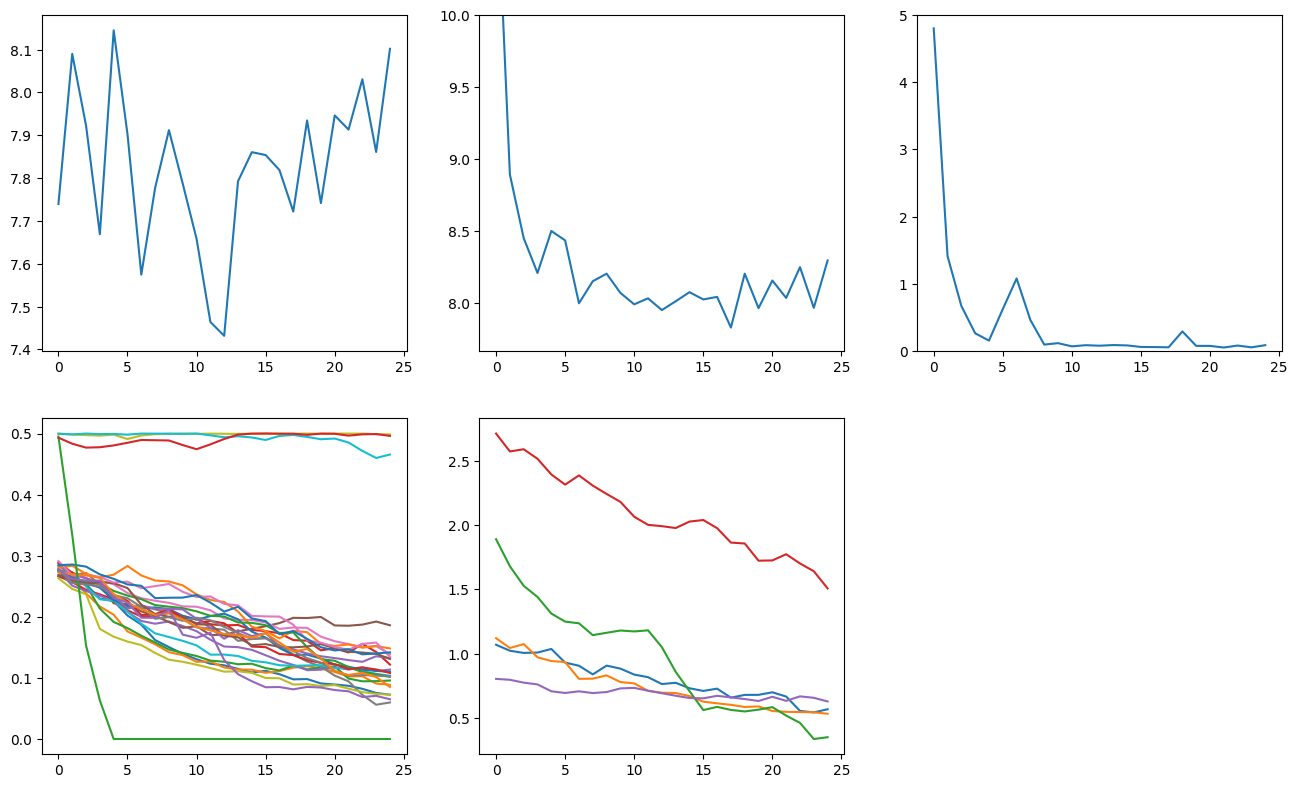

Run 1/1) Current best: 8.102, current mean: 8.297
Test mean
mae: 5.4461, rmse: 7.5691, me: 18.5481
Test std
mae: 0.0085, rmse: 0.0136, me: 0.1680


In [ ]:
df_idx = 2
current_data_list = na_list[df_idx]
metric_list = []
best_params_list = []
for spo in [3, 7, 10]:
    gs_params = {
        'X': current_data_list[0],
        'y': current_data_list[2],
        'categorical': na_categorical[df_idx],
        'population_num': 500,
        'mutation_prob': 0.05,
        'sample_size_max': 6,
        'sample_per_object': spo,
        'use_y': True
    }
    metrics, best_params, _ = repeat_gs(
        current_data_list, gs_params, runs=1,
        iter_per_run=25, to_plot=True
    )
    metric_list.append(metrics)
    best_params_list.append(best_params)

In [ ]:
metric_list

[{'mae': {'values': [np.float64(5.446931557443666)],
   'mean': np.float64(5.446931557443666),
   'std': np.float64(0.0)},
  'rmse': {'values': [np.float64(7.417982662241424)],
   'mean': np.float64(7.417982662241424),
   'std': np.float64(0.0)},
  'me': {'values': [np.float64(17.552056230583496)],
   'mean': np.float64(17.552056230583496),
   'std': np.float64(0.0)}},
 {'mae': {'values': [np.float64(5.508718924108241)],
   'mean': np.float64(5.508718924108241),
   'std': np.float64(0.0)},
  'rmse': {'values': [np.float64(7.545919391532635)],
   'mean': np.float64(7.545919391532635),
   'std': np.float64(0.0)},
  'me': {'values': [np.float64(18.215431833465537)],
   'mean': np.float64(18.215431833465537),
   'std': np.float64(0.0)}},
 {'mae': {'values': [np.float64(5.446057591240614)],
   'mean': np.float64(5.446057591240614),
   'std': np.float64(0.0)},
  'rmse': {'values': [np.float64(7.569128439347818)],
   'mean': np.float64(7.569128439347818),
   'std': np.float64(0.0)},
  'me': {

In [ ]:
for metric, spo in zip(metric_list, [3, 7, 10]):
    print('samples per object: ', spo)
    metric_printer(metric)

samples per object:  3
Metrics mean
mae: 5.4469, rmse: 7.4180, me: 17.5521
Metrics std
mae: 0.0000, rmse: 0.0000, me: 0.0000
samples per object:  7
Metrics mean
mae: 5.5087, rmse: 7.5459, me: 18.2154
Metrics std
mae: 0.0000, rmse: 0.0000, me: 0.0000
samples per object:  10
Metrics mean
mae: 5.4461, rmse: 7.5691, me: 18.5481
Metrics std
mae: 0.0000, rmse: 0.0000, me: 0.0000


In [ ]:
means_51[3] # spo 5

array([ 5.49045314,  7.57998922, 18.49295813])

In [ ]:
best_params_list

[{'hyp_num': {'values': [np.int64(4)],
   'mean': np.float64(4.0),
   'std': np.float64(0.0)},
  'min_extent_size': {'values': [np.int64(5)],
   'mean': np.float64(5.0),
   'std': np.float64(0.0)},
  'hyp_weighing': {'values': [np.int64(1)],
   'mean': np.float64(1.0),
   'std': np.float64(0.0)},
  'feature_tol': {'values': [array([0.73460872, 0.89660754, 0.56416926, 0.8040245 , 0.47401508,
           0.42738502, 0.14466916, 0.62837611, 0.63543213, 0.67045794,
           0.59455489, 0.49345982, 0.49119601, 0.46329196, 0.48101458,
           0.65235089, 0.32032809, 0.88827041, 0.        , 0.        ,
           0.58656558, 0.59404479, 0.        , 0.        , 0.72348279])],
   'mean': array([0.73460872, 0.89660754, 0.56416926, 0.8040245 , 0.47401508,
          0.42738502, 0.14466916, 0.62837611, 0.63543213, 0.67045794,
          0.59455489, 0.49345982, 0.49119601, 0.46329196, 0.48101458,
          0.65235089, 0.32032809, 0.88827041, 0.        , 0.        ,
          0.58656558, 0.5940447

In [ ]:
for best_params, spo in zip(best_params_list, [3, 7, 10]):
    print(spo)
    param_printer(best_params, list(X_5.columns))

3
		Parameters
        hyp_num: mean = 4.000, std = 0.000
min_extent_size: mean = 5.000, std = 0.000
   hyp_weighing: mean = 1.000, std = 0.000
  samp_size_low: mean = 2.000, std = 0.000
 samp_size_high: mean = 4.000, std = 0.000



7
		Parameters
        hyp_num: mean = 4.000, std = 0.000
min_extent_size: mean = 6.000, std = 0.000
   hyp_weighing: mean = 0.000, std = 0.000
  samp_size_low: mean = 3.000, std = 0.000
 samp_size_high: mean = 5.000, std = 0.000



10
		Parameters
        hyp_num: mean = 3.000, std = 0.000
min_extent_size: mean = 8.000, std = 0.000
   hyp_weighing: mean = 1.000, std = 0.000
  samp_size_low: mean = 1.000, std = 0.000
 samp_size_high: mean = 4.000, std = 0.000



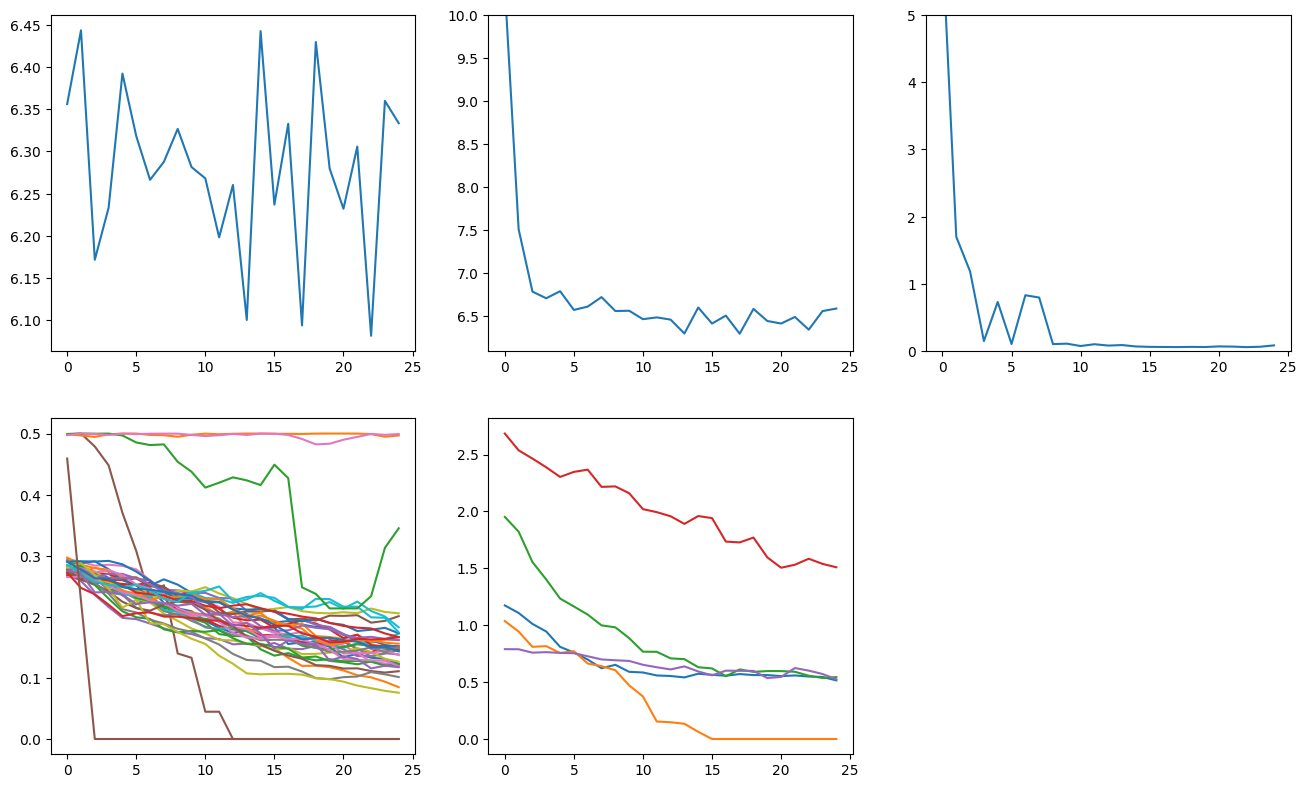

Run 1/1) Current best: 6.333, current mean: 6.588
Test mean
mae: 4.4639, rmse: 5.6618, me: 12.4215
Test std
mae: 0.2382, rmse: 0.2343, me: 0.4990


In [ ]:
df_idx = 1
current_data_list = na_list[df_idx]
metric_list = []
best_params_list = []
for spo in [3, 7, 10]:
    gs_params = {
        'X': current_data_list[0],
        'y': current_data_list[2],
        'categorical': na_categorical[df_idx],
        'population_num': 500,
        'mutation_prob': 0.05,
        'sample_size_max': 6,
        'sample_per_object': spo,
        'use_y': True
    }
    metrics, best_params, _ = repeat_gs(
        current_data_list, gs_params, runs=1,
        iter_per_run=25, to_plot=True
    )
    metric_list.append(metrics)
    best_params_list.append(best_params)

In [ ]:
for metric, spo in zip(metric_list, [3, 7, 10]):
    print('samples per object: ', spo)
    metric_printer(metric)

samples per object:  3
Metrics mean
mae: 4.1236, rmse: 5.3441, me: 12.3134
Metrics std
mae: 0.0000, rmse: 0.0000, me: 0.0000
samples per object:  7
Metrics mean
mae: 4.6639, rmse: 5.8321, me: 12.3390
Metrics std
mae: 0.0000, rmse: 0.0000, me: 0.0000
samples per object:  10
Metrics mean
mae: 4.4639, rmse: 5.6618, me: 12.4215
Metrics std
mae: 0.0000, rmse: 0.0000, me: 0.0000


In [ ]:
means_41[3] # spo 5

array([ 5.19797121,  6.32864022, 12.43121418])

In [ ]:
best_params_list

[{'hyp_num': {'values': [np.int64(6)],
   'mean': np.float64(6.0),
   'std': np.float64(0.0)},
  'min_extent_size': {'values': [np.int64(4)],
   'mean': np.float64(4.0),
   'std': np.float64(0.0)},
  'hyp_weighing': {'values': [np.int64(0)],
   'mean': np.float64(0.0),
   'std': np.float64(0.0)},
  'feature_tol': {'values': [array([0.56917795, 0.73066484, 0.75726108, 0.96217172, 0.53449395,
           0.        , 0.53600977, 0.3638301 , 0.65849048, 0.58304034,
           0.44658656, 0.48784238, 0.37728142, 0.88034937, 0.603529  ,
           0.53191919, 0.41559725, 0.19942974, 0.60760482, 0.52970936,
           0.5830054 , 0.52282856, 0.61687908, 0.61782716, 0.37037139,
           0.60502864, 0.63370303, 0.76934312, 0.74297544, 0.56613422,
           0.79885796, 0.        , 0.        , 0.73632408, 0.82441155,
           0.        , 0.        ])],
   'mean': array([0.56917795, 0.73066484, 0.75726108, 0.96217172, 0.53449395,
          0.        , 0.53600977, 0.3638301 , 0.65849048, 0.5830

In [ ]:
for best_params, spo in zip(best_params_list, [3, 7, 10]):
    print(spo)
    param_printer(best_params, list(X_4.columns))

3
		Parameters
        hyp_num: mean = 6.000, std = 0.000
min_extent_size: mean = 4.000, std = 0.000
   hyp_weighing: mean = 0.000, std = 0.000
  samp_size_low: mean = 1.000, std = 0.000
 samp_size_high: mean = 3.000, std = 0.000



7
		Parameters
        hyp_num: mean = 6.000, std = 0.000
min_extent_size: mean = 3.000, std = 0.000
   hyp_weighing: mean = 2.000, std = 0.000
  samp_size_low: mean = 1.000, std = 0.000
 samp_size_high: mean = 3.000, std = 0.000



10
		Parameters
        hyp_num: mean = 7.000, std = 0.000
min_extent_size: mean = 5.000, std = 0.000
   hyp_weighing: mean = 1.000, std = 0.000
  samp_size_low: mean = 1.000, std = 0.000
 samp_size_high: mean = 3.000, std = 0.000



### Iteration impact

Так как расчеты проводились не за один сеанс, графики построены по данным из переменных run_data, значения которых выведены в блоках с расчетами

In [ ]:
#run_40 = run_data of df_4 with nona
df_idx = 1 # run_data of 4 nona
current_data_list = nona_list[df_idx]
means_40 = []
for i in range(9, 50, 5):
    params = run_40[2]['params'][i]
    errs = test_fca(
        params, current_data_list, nona_categorical[df_idx],
        sample_size_max=6, sample_per_object=5, use_y=True,
        times=10, verbose=False
    )
    means_40.append(errs)
means_40 = np.array(means_40)

In [ ]:
#run_41 = run_data of df_4 with na
df_idx = 1 # run_data of 4 na
current_data_list = na_list[df_idx]
means_41 = []
for i in range(9, 50, 5):
    params = run_41[2]['params'][i]
    errs = test_fca(
        params, current_data_list, nona_categorical[df_idx],
        sample_size_max=6, sample_per_object=5, use_y=True,
        times=10, verbose=False
    )
    means_41.append(errs)
means_41 = np.array(means_41)

In [ ]:
#run_50 = run_data of df_5 with nona
df_idx = 2 # run_data of 5 nona
current_data_list = nona_list[df_idx]
means_50 = []
for i in range(9, 50, 5):
    params = run_50[2]['params'][i]
    errs = test_fca(
        params, current_data_list, nona_categorical[df_idx],
        sample_size_max=6, sample_per_object=5, use_y=True,
        times=10, verbose=False
    )
    means_50.append(errs)
means_50 = np.array(means_50)

In [ ]:
#run_51 = run_data of df_5 with na
df_idx = 2 # run_data of 5 nona
current_data_list = na_list[df_idx]
means_51 = []
for i in range(9, 50, 5):
    params = run_51[1]['params'][i]
    errs = test_fca(
        params, current_data_list, na_categorical[df_idx],
        sample_size_max=6, sample_per_object=5, use_y=True,
        times=10, verbose=False
    )
    means_51.append(errs)
means_51 = np.array(means_51)

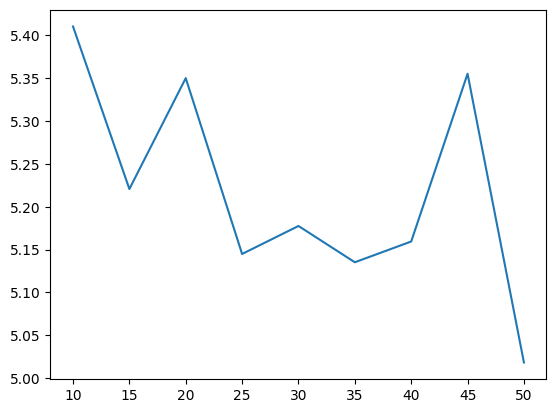

In [ ]:
plt.plot(np.arange(9, 50, 5) + 1, np.array(means_40)[:, 1]);

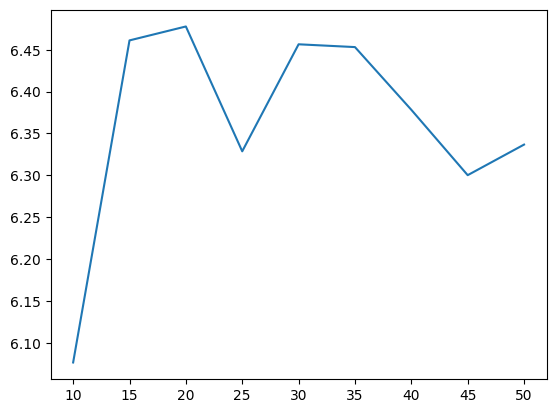

In [ ]:
plt.plot(np.arange(9, 50, 5) + 1, np.array(means_41)[:, 1]);

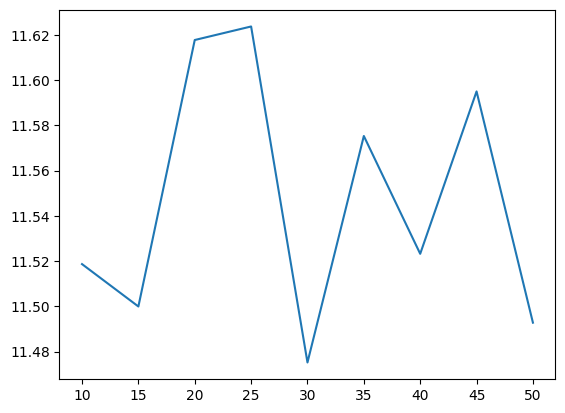

In [ ]:
plt.plot(np.arange(9, 50, 5) + 1, np.array(means_50)[:, 1]);

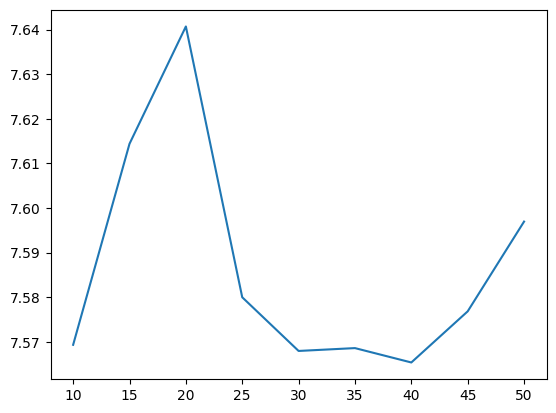

In [ ]:
plt.plot(np.arange(9, 50, 5) + 1, np.array(means_51)[:, 1]);